In [1]:
!python --version
import os
import warnings
print (os.environ['CONDA_DEFAULT_ENV'])

#suppress warnings
warnings.filterwarnings('ignore')

from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()

client

Python 3.10.16
py310_pymc_env2_linux


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45273/status,
Dashboard: http://127.0.0.1:45273/status,Workers: 4
Total threads: 8,Total memory: 62.53 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40971,Workers: 4
Dashboard: http://127.0.0.1:45273/status,Total threads: 8
Started: Just now,Total memory: 62.53 GiB
Comm: tcp://127.0.0.1:46325,Total threads: 2
Dashboard: http://127.0.0.1:44663/status,Memory: 15.63 GiB
Nanny: tcp://127.0.0.1:38615,


# 1. Workbook setups

## 1.1 Import packages

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import numpy.ma as ma
import xarray as xr
xr.set_options(file_cache_maxsize=10)


import seaborn as sns

import scipy as scipy
from scipy import stats
from scipy import signal
from scipy.integrate import trapz
import math
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit

from sklearn import linear_model, datasets
from sklearn import mixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error


from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn import preprocessing

# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

# http://scikit-learn.org/stable/modules/mixture.html
from sklearn.mixture import GaussianMixture


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors
import cmocean.cm as cmo


import proplot as plot
import cartopy.crs as ccrs

import shapefile as shp
from shapely.geometry import Point, Polygon
import shapely
from geopy.distance import distance, Distance, lonlat
import pygplates

from matplotlib import font_manager
font_manager.findfont("TeX Gyre Heros")
mpl.rcParams.update({'font.sans-serif':'TeX Gyre Heros',
                    'font.weight': 'normal',
                    'axes.labelweight': 'normal',
                    'axes.titleweight': 'normal',
                    'pdf.fonttype':42,
                    'ps.fonttype':42
                     })

import string
import os
import requests
import io
from tqdm import tqdm
import time
import copernicusmarine

## 1.2 Miscellaneous codes

In [3]:
def _woa_variable(variable):
    '''
    codes to generate woa urls modified from https://pyoceans.github.io/python-oceans/_modules/oceans/datasets.html
    variables:
        'temperature': 't',
        'salinity': 's',
        'silicate': 'i',
        'phosphate': 'p',
        'nitrate': 'n',
        'oxygen_saturation': 'O',
        'dissolved_oxygen': 'o',
        'apparent_oxygen_utilization': 'A',
        'AOU': 'A',
        "density":"I",
        'mld':"M"
   time_periods:
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
   resolutions:
    '5': ('5deg', '5d'),
    '1': ('1.00', '01'),
    '04': ('0.25', '04'),
        

    an=Objectively analyzed climatologies are the objectively interpolated mean fields 
    for oceanographic variables at standard depth levels for the World Ocean.
    mn=The statistical mean is the average of all unflagged interpolated values at each 
    standard depth level for each variable in each 1° square which contains at least one
    '''
    _VAR = {
        'temperature': 't',
        'salinity': 's',
        'silicate': 'i',
        'phosphate': 'p',
        'nitrate': 'n',
        'oxygen_saturation': 'O',
        'oxygen': 'o',
        'apparent_oxygen_utilization': 'A',
        'AOU': 'A',
        "density":"I",
        'mld':"M02"
    }
    v = _VAR.get(variable)
    if not v:
        raise ValueError(
            f'Unrecognizable variable. Expected one of {list(_VAR.keys())}, got "{variable}".'
        )
    return v

def _woa_url(variable, time_period, resolution):
    # base = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC' ## original link from the source code
    base2 = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/'

    v = _woa_variable(variable)
    grids = {
        '5': ('5deg', '5d'),
        '1': ('1.00', '01'),
        '04': ('0.25', '04'),
    }
    
    grid = grids.get(resolution)
    if not grid:
        raise ValueError(
            f'Unrecognizable resolution. Expected one of {list(grids.keys())}, got "{resolution}".'
        )
        
    res = grid[0]
    gg = grid[1]

    time_periods = {
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
    }
    
    pref = 'woa18'
    
    time_period = time_period.lower()
    if len(time_period) == 3:
        tt = [time_periods.get(k) for k in time_periods.keys() if k.startswith(time_period)][0]
    elif len(time_period) == 2 and time_period in time_periods.values():
        tt = time_period
    else:
        tt = time_periods.get(time_period)
        

    if not tt:
        raise ValueError(
            f'Unrecognizable time_period. '
            f'Expected one of {list(time_periods.keys())}, got "{time_period}".'
        )
        
    if variable not in ['salinity', 'temperature','density','mld']:
        warnings.warn(
            f'The variable "{variable}" is only available at 1 degree resolution, '
            f'annual time period, and "{pref}".'
        )
        dddd = 'all'
   
    else:
        if variable == 'mld':
            dddd = 'decav81B0'
        elif variable == "temperature":
            dddd = 'decav'
        else:
            dddd = 'all'
    
    
    url = (
        f'{base2}'
        f'{variable}/{dddd}/{res}/'
        f'{pref}_{dddd}_{v}{tt}_{gg}.nc'  # '[PREF]_[DDDD]_[V][TT][FF][GG]' Is [FF] used?
    )            
    return url

##### WOA23 Data base url loader #############
def _woa23_url(variable, time_period, resolution):
    # base = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC' ## original link from the source code
    base_woa23 = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/'

    v = _woa_variable(variable)
    grids = {
        '5': ('5deg', '5d'),
        '1': ('1.00', '01'),
        '04': ('0.25', '04'),
    }
    
    grid = grids.get(resolution)
    if not grid:
        raise ValueError(
            f'Unrecognizable resolution. Expected one of {list(grids.keys())}, got "{resolution}".'
        )
        
    res = grid[0]
    gg = grid[1]

    time_periods = {
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
    }
    
    pref = 'woa23'
    
    time_period = time_period.lower()
    if len(time_period) == 3:
        tt = [time_periods.get(k) for k in time_periods.keys() if k.startswith(time_period)][0]
    elif len(time_period) == 2 and time_period in time_periods.values():
        tt = time_period
    else:
        tt = time_periods.get(time_period)
        

    if not tt:
        raise ValueError(
            f'Unrecognizable time_period. '
            f'Expected one of {list(time_periods.keys())}, got "{time_period}".'
        )
        
    if variable not in ['salinity', 'temperature','density','mld']:
        warnings.warn(
            f'The variable "{variable}" is only available at 1 degree resolution, '
            f'annual time period, and "{pref}".'
        )
        dddd = 'all'
   
    else:
        if variable == 'mld':
            dddd = 'decav81B0'
        elif ((variable == "temperature") or (variable == "salinity")):
            dddd = 'decav'
        else:
            dddd = 'all'
    
    
    url = (
        f'{base_woa23}'
        f'{variable}/netcdf/{dddd}/{res}/'
        f'{pref}_{dddd}_{v}{tt}_{gg}.nc'  # '[PREF]_[DDDD]_[V][TT][FF][GG]' Is [FF] used?
    )            
    return url

def round_to_nearest_half_int(num):
    return round(num * 2) / 2

def getClosestPoint_fromLineString(LineString_input,point1):
    if "MultiLineString" in str(type(LineString_input)):
        multiLineString = LineString_input
        len_multiLineString = len(multiLineString.geoms)
        idxMin = np.array([multiLineString.geoms[i].distance(point1) for i in range(len_multiLineString)]).argmin()
        
        LineString = multiLineString.geoms[idxMin]
    elif "Polygon" in str(type(LineString_input)):
        
        polygon_input = LineString_input
        LineString = polygon_input.exterior
        
    else:
        LineString = LineString_input
        
    Coords = LineString.coords
    x, y = Coords.xy

    coords_df = pd.DataFrame({'LON':x,'LAT':y})
    coords_df['LAT_diff'] = abs(point1.y-coords_df.LAT)
    coords_df['LON_diff'] = abs(point1.x-coords_df.LON)
    coords_df['LONLAT_diff_sum'] = coords_df['LAT_diff']+coords_df['LON_diff']
    lat2,lon2 = coords_df.LAT.iloc[coords_df.LONLAT_diff_sum.idxmin()],coords_df.LON.iloc[coords_df.LONLAT_diff_sum.idxmin()]
    point2 = Point(lon2,lat2)
    return point2

def distance_haversine(origin, destination, output_unit='km'):
    import math
    lon1, lat1 = origin
    lon2, lat2 = destination
    
    if output_unit=='km':
        radius = 6371
    elif output_unit=='mi':
        radius = 3956
    elif output_unit=='m':
        radius = 6371000
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

# Define usefull functions:
def vrange(V): # Return the array value range
    return [np.min(V),np.max(V)]
def vrangec(V): # Return the array value centered range 
    xl = np.max(np.abs(vrange(V)))
    return np.array([-xl,xl])

def nonnan_gradient(array, axis=None, edge_order=1):
  """Computes the gradient of an array, ignoring NaN values.

  Args:
    array: An N-dimensional array containing samples of a scalar function.
    axis: The axis along which to compute the gradient. If None, the gradient
      is computed for all axes.
    edge_order: The order of the accuracy of the approximation at the edges of
      the array.

  Returns:
    An N-dimensional array or a list of N-dimensional arrays representing the
    gradient.
  """

  # Create a mask of non-NaN values.
  mask = np.isfinite(array)

  # Compute the gradient of the masked array.
  gradient = np.gradient(array, axis=axis, edge_order=edge_order)

  # Set the gradient to zero wherever the mask is False.
  for i in range(len(gradient)):
    gradient[i][~mask] = 0

  return gradient

## 1.3 Dictionaries

In [4]:
ringNumbers_dict_zhang16 = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':4, 
    'fGDGT_cren':4,
    'reported_1292_iso':4,
    'fGDGT_cren_prime':4,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}

ringNumbers_dict_revised = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':5, 
    'fGDGT_cren':5,
    'reported_1292_iso':5,
    'fGDGT_cren_prime':5,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}


def label_pvalues(x):
    if x<0.001:
        return r'$\it{p}$<.001'
    elif x<0.01:
        return r'$\it{p}$<.01'
    elif x<0.05:
        return r'$\it{p}$<.05'
    elif x<0.1:
        return r'$\it{p}$<.1'
    elif x>=0.1:
        return r'$\it{p}$>.1'


## 1.4 Set local paths

In [5]:
# set the path to local folder other than github

### 1.4.1 Local path on PC
local_documents_path = '/home/ronnie/Documents' ### this is the path when code is run on Linux

### 1.4.2 Path to github folder
gitpath_idx = os.getcwd().find('nutrient-effect-on-TEX')+len('nutrient-effect-on-TEX')
local_github_path = os.getcwd()[:gitpath_idx]

### 1.4.3 Path to OneDrive folder
local_onedrive_path = '/home/ronnie/OneDrive'

# 2. Import data

## 2.1 Coretop compilation

In [6]:
fpath = os.path.join(local_github_path,'spreadsheets')
fname = r'texmarine-revised-2024.csv'

coretop_df = pd.read_csv(os.path.join(fpath,fname))

coretop_df = coretop_df.rename(
    columns={
        'latitude':'Latitude',
        'longitude':'Longitude',
        'depth':'modernWaterDepth',
        'tex86':'TEX86',
        'bit':'BIT'
    }
)

#### Additional parameters
coretop_df['publicationYear'] = [int(row[-4:]) if row[-4:].isdigit() else 'This Study' for row in coretop_df['reference_name']]

features = ['fGDGT_0', 'fGDGT_1', 'fGDGT_2', 'fGDGT_3','fGDGT_cren', 'fGDGT_cren_prime']
coretop_df['RI_zhang16'] = np.array([coretop_df[features[i]]*ringNumbers_dict_zhang16.get(features[i]) for i in range(len(features))]).sum(axis=0)
coretop_df['RI_zhang16_revised'] = np.array([coretop_df[features[i]]*ringNumbers_dict_revised.get(features[i]) for i in range(len(features))]).sum(axis=0)


features2 = ['fGDGT_0', 'fGDGT_1', 'fGDGT_2', 'fGDGT_3','fGDGT_cren', 'fGDGT_cren_prime']
coretop_df['RI_0to5'] = np.array([coretop_df[features2[i]]*ringNumbers_dict_revised.get(features2[i]) for i in range(len(features2))]).sum(axis=0)

coretop_df['gdgt23ratio'] = coretop_df['fGDGT_2']/coretop_df['fGDGT_3']
coretop_df['methaneIndex'] = coretop_df[['fGDGT_1', 'fGDGT_2', 'fGDGT_3']].sum(axis=1)/coretop_df[['fGDGT_1', 'fGDGT_2', 'fGDGT_3','fGDGT_cren', 'fGDGT_cren_prime']].sum(axis=1)
coretop_df['gdgtZeroOverZeroCren'] = (coretop_df['fGDGT_0']/coretop_df[['fGDGT_0','fGDGT_cren']].sum(axis=1))

temp_sampleID = ['TEXAS_PSM_RR'+str(i).zfill(5) for i in range(1,len(coretop_df)+1)]
coretop_df.insert(0,'sampleID',temp_sampleID)

#### copy coretop_df to coretop_df2 to keep the original df
coretop_df2 = coretop_df.dropna(how='any', subset=['TEX86','fGDGT_0']).reset_index(drop=True)
coretop_df2['BIT'] = coretop_df2['BIT'].fillna(-999)
coretop_df2['methaneIndex']= coretop_df2['methaneIndex'].fillna(-999)
coretop_df2['gdgtZeroOverZeroCren'] = coretop_df2['fGDGT_0'].fillna(-999)


coretop_df2['QC_flag'] = ['include' if ((coretop_df2['BIT'].iloc[i] <= 0.5) & (coretop_df2['methaneIndex'].iloc[i] <= 0.5) & (coretop_df2['gdgtZeroOverZeroCren'].iloc[i] <= 0.67)) else 'exclude' for i in range(len(coretop_df2))]
coretop_df2

,sampleID,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,fGDGT_0,...,reference_name,remark,reference_link,RI_zhang16,RI_zhang16_revised,RI_0to5,gdgt23ratio,methaneIndex,gdgtZeroOverZeroCren,QC_flag
0,TEXAS_PSM_RR00002,KNR195-5 MC11,MC,6.0,8.0,-1.5327,-86.7852,2288.0,0.602873,0.330589,...,this study,NaN,NaN,2.341606,2.874369,2.874369,13.185451,0.204131,0.330589,include
1,TEXAS_PSM_RR00005,KNR195-5 MC18,MC,4.0,6.0,-3.9690,-81.3100,1024.0,0.599447,0.282415,...,this study,NaN,NaN,2.566525,3.158231,3.158231,4.882710,0.175419,0.282415,include
2,TEXAS_PSM_RR00007,KNR195-5 MC25,MC,5.0,7.0,-3.5830,-81.1650,381.0,0.617192,0.292011,...,this study,NaN,NaN,2.503135,3.072126,3.072126,4.409615,0.196327,0.292011,include
3,TEXAS_PSM_RR00008,KNR195-5 MC33,MC,3.0,5.0,-3.2237,-82.9142,2949.0,0.605147,0.309270,...,this study,NaN,NaN,2.427417,2.980611,2.980611,6.868635,0.199117,0.309270,include
4,TEXAS_PSM_RR00009,KNR195-5 MC34,MC,4.0,6.0,-3.5975,-83.9632,3224.0,0.588670,0.344233,...,this study,NaN,NaN,2.248913,2.751584,2.751584,8.430655,0.233462,0.344233,include
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,TEXAS_PSM_RR02077,SY201710_LD-18,NaN,NaN,NaN,20.5700,113.8000,89.0,0.595556,0.236000,...,Wei2020,Data from original source,NaN,2.601000,3.170000,3.170000,3.000000,0.255236,0.236000,include
2018,TEXAS_PSM_RR02078,DO201207-08_QD11a,NaN,NaN,NaN,20.7000,113.3700,81.0,0.512500,0.281000,...,Wei2020,Data from original source,NaN,2.525000,3.099000,3.099000,2.941176,0.201669,0.281000,include
2019,TEXAS_PSM_RR02079,DO201207-08_QD41,NaN,NaN,NaN,20.1400,112.0600,87.0,0.585859,0.236000,...,Wei2020,Data from original source,NaN,2.652000,3.244000,3.244000,3.090909,0.225131,0.236000,include
2020,TEXAS_PSM_RR02080,DO201207-08_E503,NaN,NaN,NaN,19.2000,112.2900,189.0,0.651376,0.237000,...,Wei2020,Data from original source,NaN,2.647000,3.235000,3.235000,3.714286,0.229358,0.237000,include


In [7]:
fpath = os.path.join(local_github_path,'spreadsheets')
fname = r'palo20496-sup-0002-supinfo.csv'

coretop_uk_df = pd.read_csv(os.path.join(fpath,fname),encoding='latin1')
coretop_uk_df

,core_name,core_type,sample_depth_start,sample_depth_end,latitude,longitude,wdepth,UK37,include,reference_name,reference_link,notes
0,GeoB5844-2,GC,-999.0,-999.0,27.714,34.682,963.0,0.950,1,Arz2003 Leduc2010,http://dx.doi.org/10.1126/science.1080325 ht...,backcalculated from sst=26.8
1,SU81-18,PC,10.0,11.0,37.767,-10.183,3135.0,0.637,1,Bard2000 Leduc2010,http://dx.doi.org/10.1126/science.289.5483.132...,NaN
2,SO136-GC11,GC,-999.0,-999.0,-43.440,167.851,1556.0,0.539,1,Barrows2007 Leduc2010,http://dx.doi.org/10.1126/science.1145873 htt...,backcalculated from sst=15
3,GeoB15104-1,MC,0.0,2.0,40.800,27.720,606.0,0.617,1,Becker2015,http://dx.doi.org/10.1016/j.orggeochem.2015.04...,NaN
4,JR51-GC35,PC,-999.0,-999.0,66.999,-17.961,420.0,0.231,1,Bendle2007 Leduc2010,http://dx.doi.org/10.1177/0959683607073269 ht...,backcalculated from sst=4.6
...,...,...,...,...,...,...,...,...,...,...,...,...
1339,PS75/101-2,MC,0.0,1.0,-45.758,175.876,1773.0,0.324,1,Ho2012,http://dx.doi.org/10.1029/2012PA002317,NaN
1340,PS75/063-2,MC,0.0,1.0,-58.904,-135.629,4147.0,0.093,1,Ho2012,http://dx.doi.org/10.1029/2012PA002317,NaN
1341,RS147-GC017,GC,1.0,2.0,-47.750,145.817,3300.0,0.383,1,Sikes2009,http://dx.doi.org/10.1029/2008PA001659,NaN
1342,RS147-GC07,GC,1.0,2.0,-45.150,146.283,3300.0,0.584,1,Sikes2009,http://dx.doi.org/10.1029/2008PA001659,NaN


## 2.2 Ocean products

### 2.2.1 WOA23 - Temperature 0.25deg x 0.25deg

WOA = World Ocean Atlas
Details:
- Temperature - Statistical mean on 1/4° grid for 1971-2000 climate normal
- Unit: Degree Celcius
- Link to download data: https://www.ncei.noaa.gov/thredds-ocean/fileServer/woa23/DATA/temperature/netcdf/decav71A0/0.25/woa23_decav71A0_t00_04.nc

In [8]:
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
ts = xr.open_dataset(os.path.join(fpath2,'woa23_decav71A0_t00_01.nc'),decode_times=False).drop('time')

T_da_01 = ts.isel(time=0).t_an.load()
T_da_01


<xarray.DataArray 't_an' (depth: 102, lat: 180, lon: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.64341  , -1.64421  , -1.64491  , ..., -1.64151  ,
         -1.64201  , -1.64271  ],
        [-1.63731  , -1.63671  , -1.6371   , ..., -1.64641  ,
         -1.63721  , -1.63721  ],
        [-1.62861  , -1.62861  , -1.62861  , ..., -1.62861  ,
         -1.62861  , -1.62861  ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [9]:
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
ts = xr.open_dataset(os.path.join(fpath2,'woa23_decav71A0_t00_04.nc'),decode_times=False).drop('time')

T_da = ts.isel(time=0).t_an.load()
T_da

<xarray.DataArray 't_an' (depth: 102, lat: 720, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.64081  , -1.64411  , -1.64031  , ..., -1.66391  ,
         -1.6435   , -1.64231  ],
        [-1.6669   , -1.66691  , -1.66691  , ..., -1.66681  ,
         -1.66681  , -1.66681  ],
        [-1.66871  , -1.66871  , -1.66871  , ..., -1.66871  ,
         -1.66871  , -1.66871  ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [10]:
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/calculated-properties'
fname = 'WOA23_mingrad_thermocline_integral_04degReso_revised.nc'
thermocline_T_integral_da = xr.open_dataset(os.path.join(fpath,fname),decode_times=False).thermo_integral.load()
thermocline_T_integral_da

<xarray.DataArray 'thermo_integral' (lat: 720, lon: 1440)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-1.48574126, -1.48628342, -1.48646832, ..., -1.48584414,
        -1.48539674, -1.48565447],
       [-1.49165857, -1.4918884 , -1.49210393, ..., -1.49090397,
        -1.4911027 , -1.49129009],
       [-1.49897289, -1.49897289, -1.49897289, ..., -1.49897289,
        -1.49897289, -1.49897289]])
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 0.0
    time     float32 1.878e+03

In [11]:
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/calculated-properties'
fname = 'WOA23_mingrad_thermocline_depth_04degReso_revised.nc'

thermocline_depth_da = xr.open_dataset(os.path.join(fpath,fname),decode_times=False).thermo_depth.load()
thermocline_depth_da

<xarray.DataArray 'thermo_depth' (lat: 720, lon: 1440)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [175., 175., 175., ..., 175., 175., 175.],
       [175., 175., 175., ..., 175., 175., 175.],
       [175., 175., 175., ..., 175., 175., 175.]])
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 0.0
    time     float32 1.878e+03

#### Calculate gridded thermocline depth and depth-integrated thermocline T with xarray

In [12]:
### calculate thermocline along depth dimension of T_da using min T gradient approach (depth with the fastest drop in T)
### calculate using diff method from xarray and divide by the diff of depth
sliced_T_da = T_da.sel(depth=slice(0,1100))
gradient = sliced_T_da.diff('depth')/sliced_T_da.depth.diff('depth')

### mask NaN values
gradient = abs(gradient.where(~np.isnan(T_da)))

### fill NaN values with infinity to avoid error in argmin
gradient_filled = gradient.fillna(-np.inf)
maxabs_gradient_idx = gradient_filled.argmax('depth',skipna=True).astype(int)+1

### mask locations where all depth values are NaN
all_nan_mask = np.isnan(sliced_T_da).all('depth')

### mask maxabs_gradient_idx where all depth values are NaN
maxabs_gradient_idx = maxabs_gradient_idx.where(~all_nan_mask, drop=False)

# Flatten the lat-lon grid for advanced indexing
stacked = sliced_T_da.stack(grid=["lat", "lon"])

# Ensure maxabs_gradient_idx is an integer, replacing NaN with a valid placeholder index (e.g., 0)
valid_idx = maxabs_gradient_idx.fillna(0).astype(int)

# Use isel to index the depth dimension with the flattened indices
thermoT_depth_values = stacked["depth"].isel(depth=valid_idx.stack(grid=["lat", "lon"]))
thermoT_values = stacked.isel(depth=valid_idx.stack(grid=["lat", "lon"]))
# Mask locations where maxabs_gradient_idx was NaN
nan_mask = maxabs_gradient_idx.isnull()
thermoT_depth_values = thermoT_depth_values.where(~nan_mask.stack(grid=["lat", "lon"]))
thermoT_values = thermoT_values.where(~nan_mask.stack(grid=["lat", "lon"]))
# Unstack to return to the original lat-lon dimensions
thermoT_depth_da = thermoT_depth_values.unstack("grid")
thermoT_da = thermoT_values.unstack("grid")
masked_T_da = T_da.where(T_da["depth"]<=thermoT_depth_da)


In [13]:
len_notnull_values_along_depth = np.unique(masked_T_da.notnull().sum('depth').values)
sel_masked_da = masked_T_da
tmp_da = xr.DataArray(np.zeros_like(sel_masked_da.isel(depth=0).values),
                      dims=sel_masked_da.isel(depth=0).dims,
                      coords=sel_masked_da.isel(depth=0).coords
                      )
tmp_da
# Loop through the unique counts of non-NaN values along depth
for i in len_notnull_values_along_depth:
    if i == 0:
        continue  # Skip cases where no valid data is available
    # Select grid points where the non-NaN count equals `i`
    mask = sel_masked_da.notnull().sum('depth') == i
    
    if i == 1:
        # if only one valid depth slice, use the first depth slice
        cal_values = (
            sel_masked_da.where(sel_masked_da.notnull().sum('depth') == i)
            .isel(depth=0)
        )
    else:
        # Calculate the integrated values for the valid depth slices
        cal_values = (
            sel_masked_da.where(sel_masked_da.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .integrate('depth')
        )
        
        # Update tmp_da with the calculated values at the same grid points
    tmp_da = tmp_da.where(~mask, other=cal_values)
tmp_da2 = tmp_da
#### mask locations where there are more than 1 valid depth values
mask_below_SST = sel_masked_da.notnull().sum('depth') > 1
cal_values = tmp_da2.where(mask_below_SST)/thermoT_depth_da.where(mask_below_SST)
# apply mask where all depth values are NaN
all_nan_mask = np.isnan(sel_masked_da).all('depth')
tmp_da2 = tmp_da2.where(~all_nan_mask)

thermocline_depthIntegral_T_da = tmp_da2.where(~mask_below_SST, other=cal_values)
thermocline_depthIntegral_T_da

<xarray.DataArray (lat: 720, lon: 1440)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-1.3260654, -1.3265443, -1.3267593, ..., -1.3259107, -1.3255987,
        -1.3259116],
       [-1.3309795, -1.3312201, -1.3314477, ..., -1.3301692, -1.3303967,
        -1.3306143],
       [-1.3382853, -1.3382853, -1.3382853, ..., -1.3382853, -1.3382853,
        -1.3382853]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 0.0

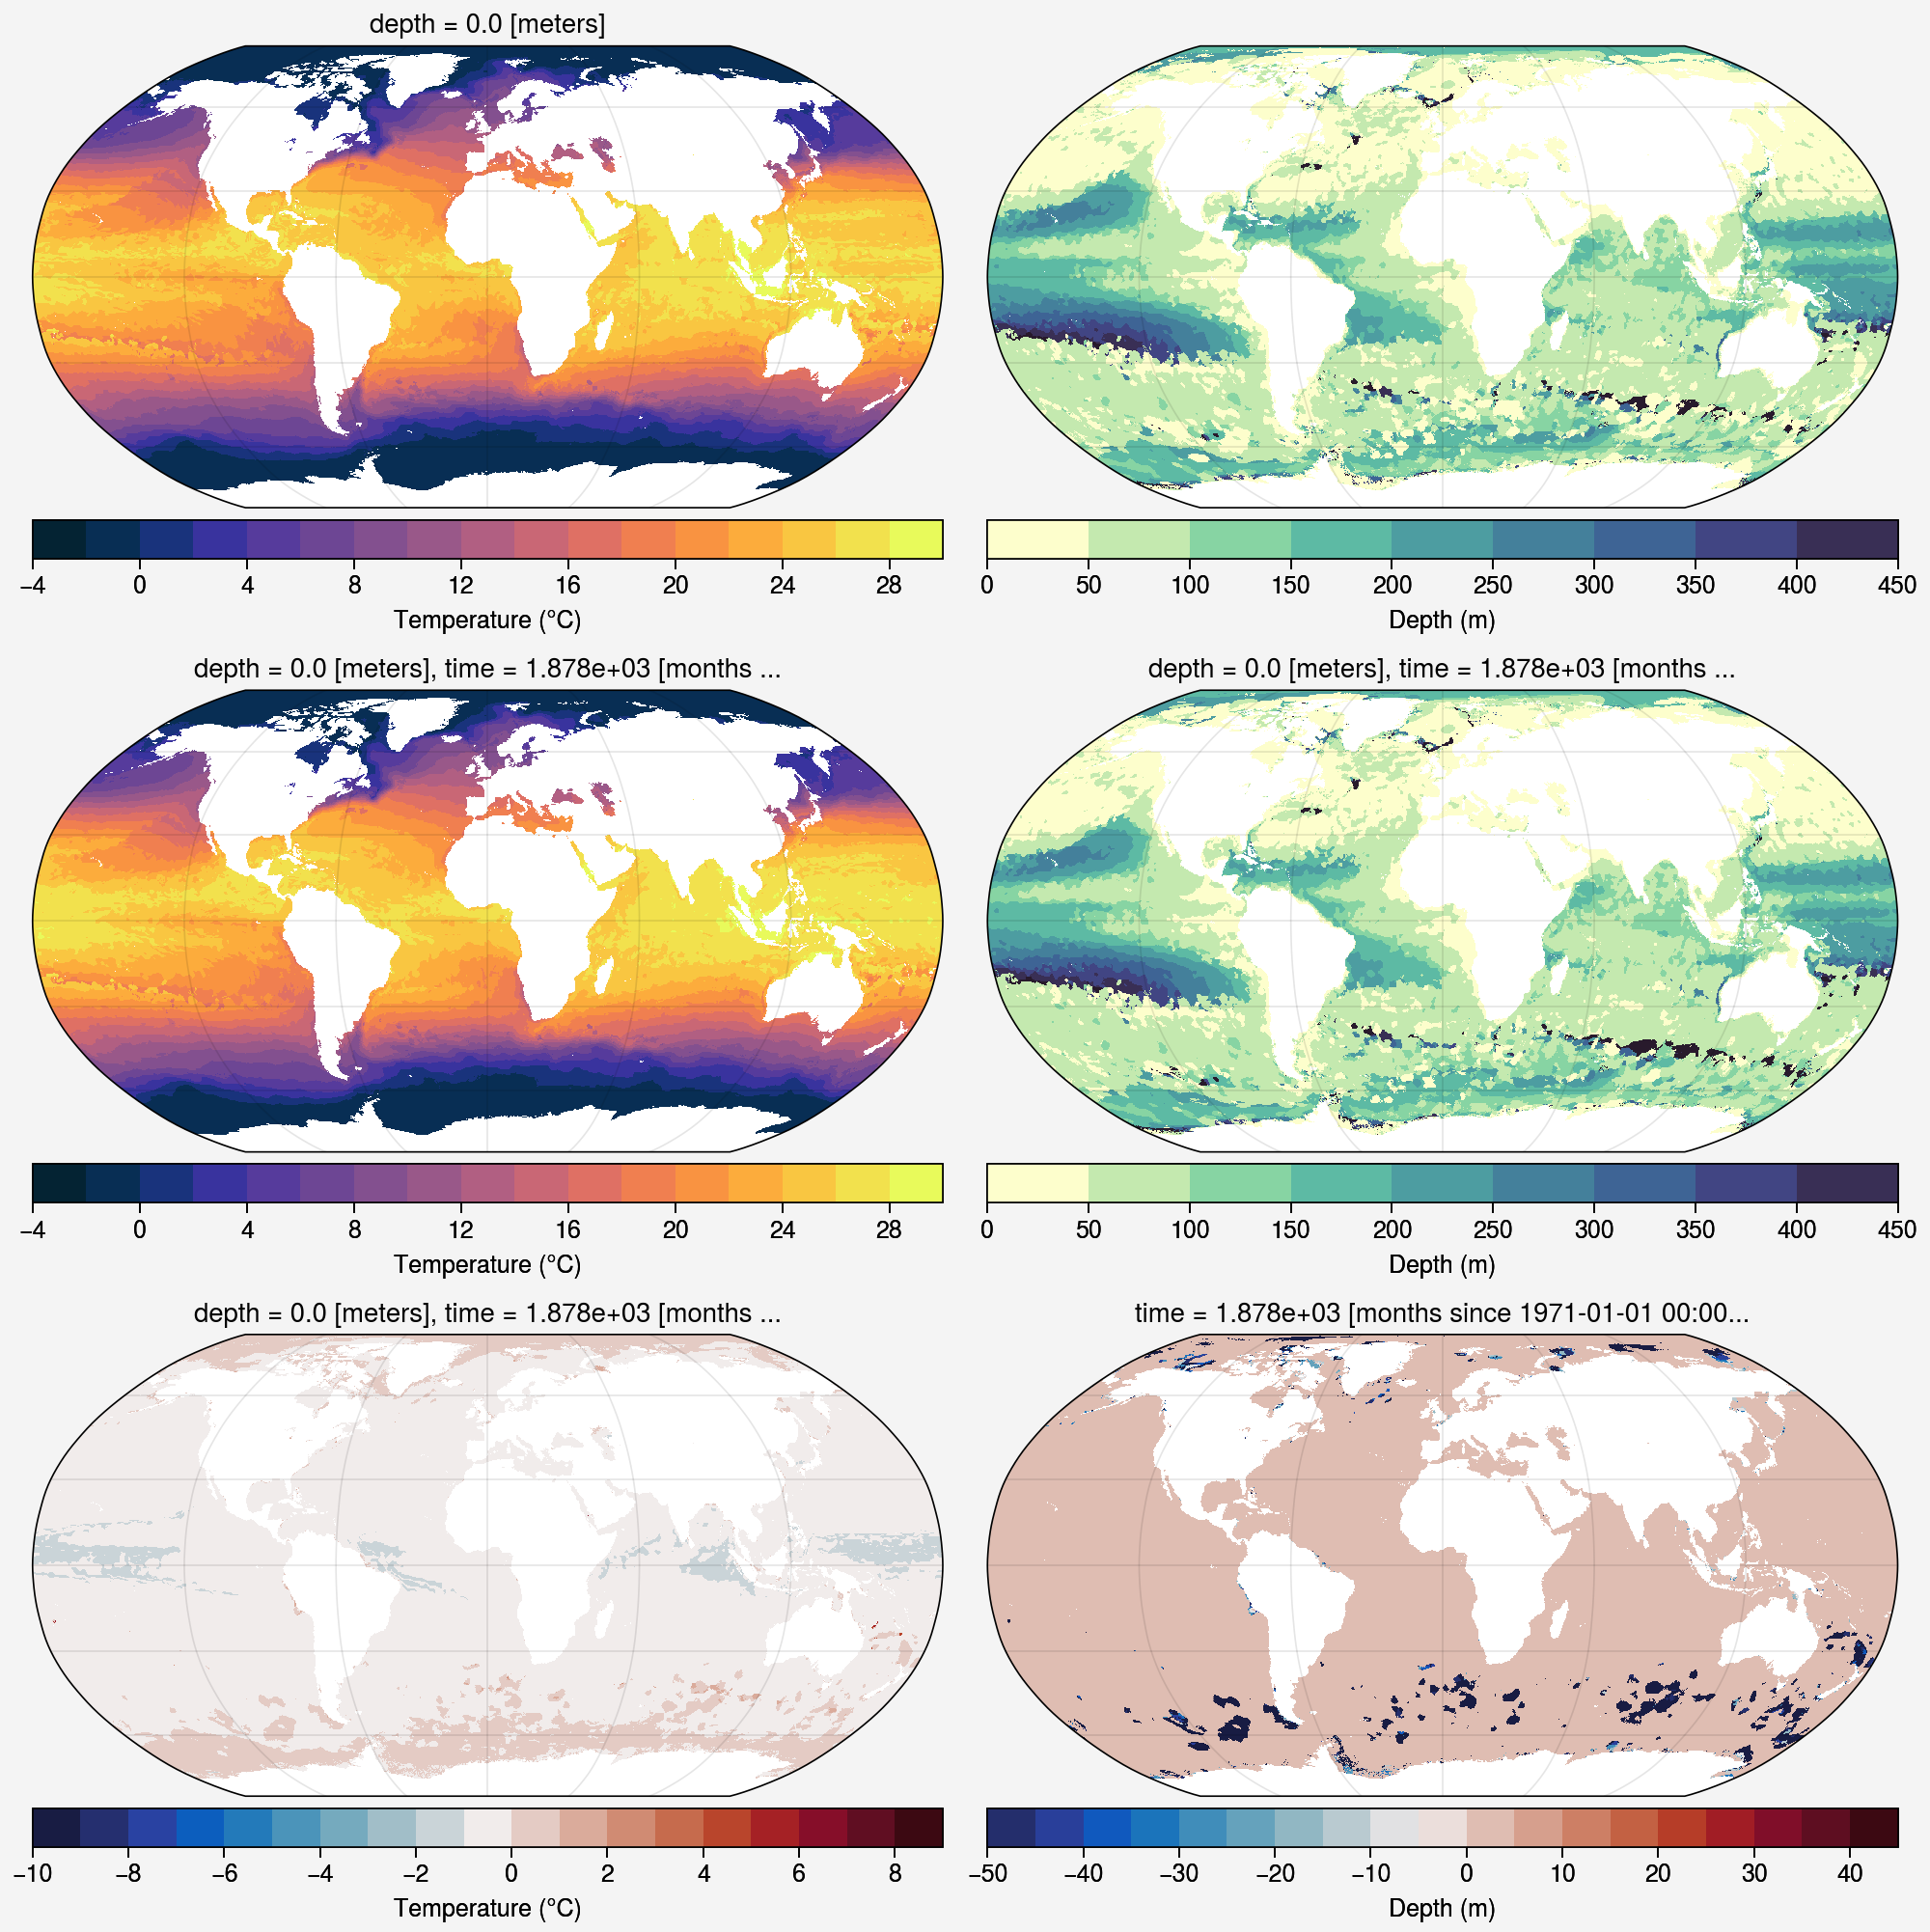

In [14]:
fig, axs = plot.subplots(proj='robin',width=10,nrows=3,ncols=2)
ax = axs[0,0]

m = thermocline_depthIntegral_T_da.plot(ax=ax,
                        cmap='cmo.thermal',
                        add_colorbar=False,
                        levels=np.arange(-4,31,2),
                        )
ax.colorbar(m, loc='b', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,4),
            tickminor=False,
            )

ax = axs[0,1]
m = thermoT_depth_da.plot(ax=ax,
                cmap='cmo.deep',
                add_colorbar=False,
                levels=np.arange(0,500,50),
                )
ax.colorbar(m, loc='b', label='Depth (m)',
            ticks=np.arange(0,500,50),
            tickminor=False,
            )



### add contour line of 28 degree isotherm of the calculated thermocline dataarray
ax = axs[1,0]
m=thermocline_T_integral_da.plot(ax=ax,
                                cmap='cmo.thermal',
                                levels=np.arange(-4,31,2),
                                add_colorbar=False,
                                )
ax.colorbar(m, loc='b', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,4),
            tickminor=False,
            )

ax = axs[1,1]
m=thermocline_depth_da.plot(ax=ax,
                            cmap='cmo.deep',
                            levels=np.arange(0,500,50),
                            add_colorbar=False,
                            )
ax.colorbar(m, loc='b', label='Depth (m)',
            ticks=np.arange(0,500,50),
            tickminor=False,
            )
#########################################3
ax = axs[2,0]
diff = thermocline_depthIntegral_T_da-thermocline_T_integral_da
m = diff.plot(ax=ax,
              cmap='cmo.balance',
              levels=np.arange(-10,10,1),
              add_colorbar=False,
              )
ax.colorbar(m,label='Temperature (\N{DEGREE SIGN}C)',loc='b',
            ticks=np.arange(-10,10,1),
            tickminor=False,
            )

ax = axs[2,1]
depth_diff = thermoT_depth_da-thermocline_depth_da
m = depth_diff.plot(ax=ax,
                    cmap='cmo.balance',
                    levels=np.arange(-50,50,5),
                    add_colorbar=False,
                    )
ax.colorbar(m,label='Depth (m)',loc='b',
            ticks=np.arange(-50,50,5),
            tickminor=False,
            )

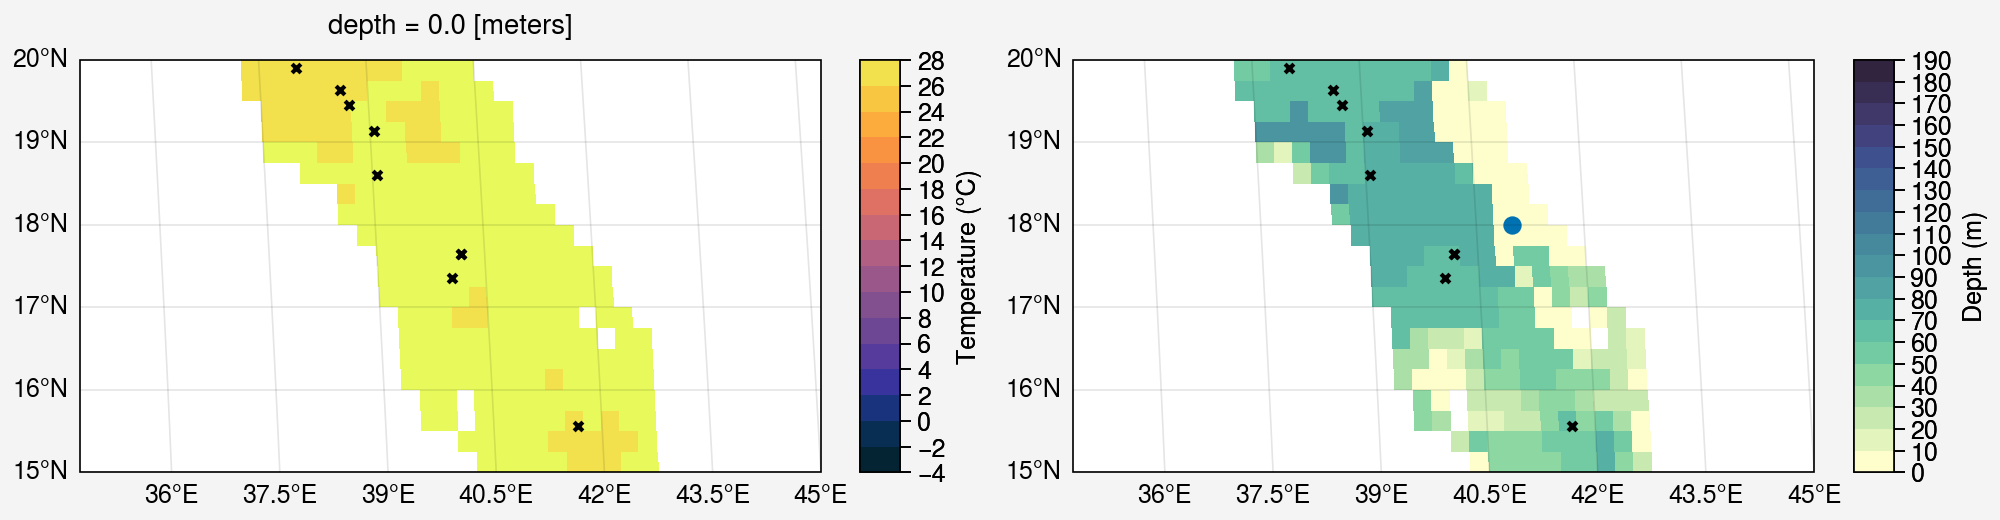

In [15]:
fig, axs = plot.subplots(proj='robin',width=10,ncols=2)
axs.format(
    latlim=(15,20),
    lonlim=(35,45),
    latlabels=True,lonlabels=True
)

ax = axs[0]
thermocline_depthIntegral_T_da.plot(ax=ax,robust=True,
                                    cmap=cmo.thermal,
                                    levels=np.arange(-4,30,2),
                                    cbar_kwargs={'label':'Temperature (°C)'}
                                    )

ax.scatter(coretop_df2['Longitude'],coretop_df2['Latitude'],s=10,c='k',marker='x',label='Coretops')

ax = axs[1]
thermoT_depth_da.plot(ax=ax,robust=True,
                cmap=cmo.deep,
                levels=np.arange(0,200,10),
                cbar_kwargs={'label':'Depth (m)'}
                )

ax.scatter(coretop_df2['Longitude'],coretop_df2['Latitude'],s=10,c='k',marker='x',label='Coretops')
ax.scatter(41,18)

(<matplotlib.collections.PathCollection at 0x7f7431236b00>,
 <matplotlib.collections.PathCollection at 0x7f7431236500>)

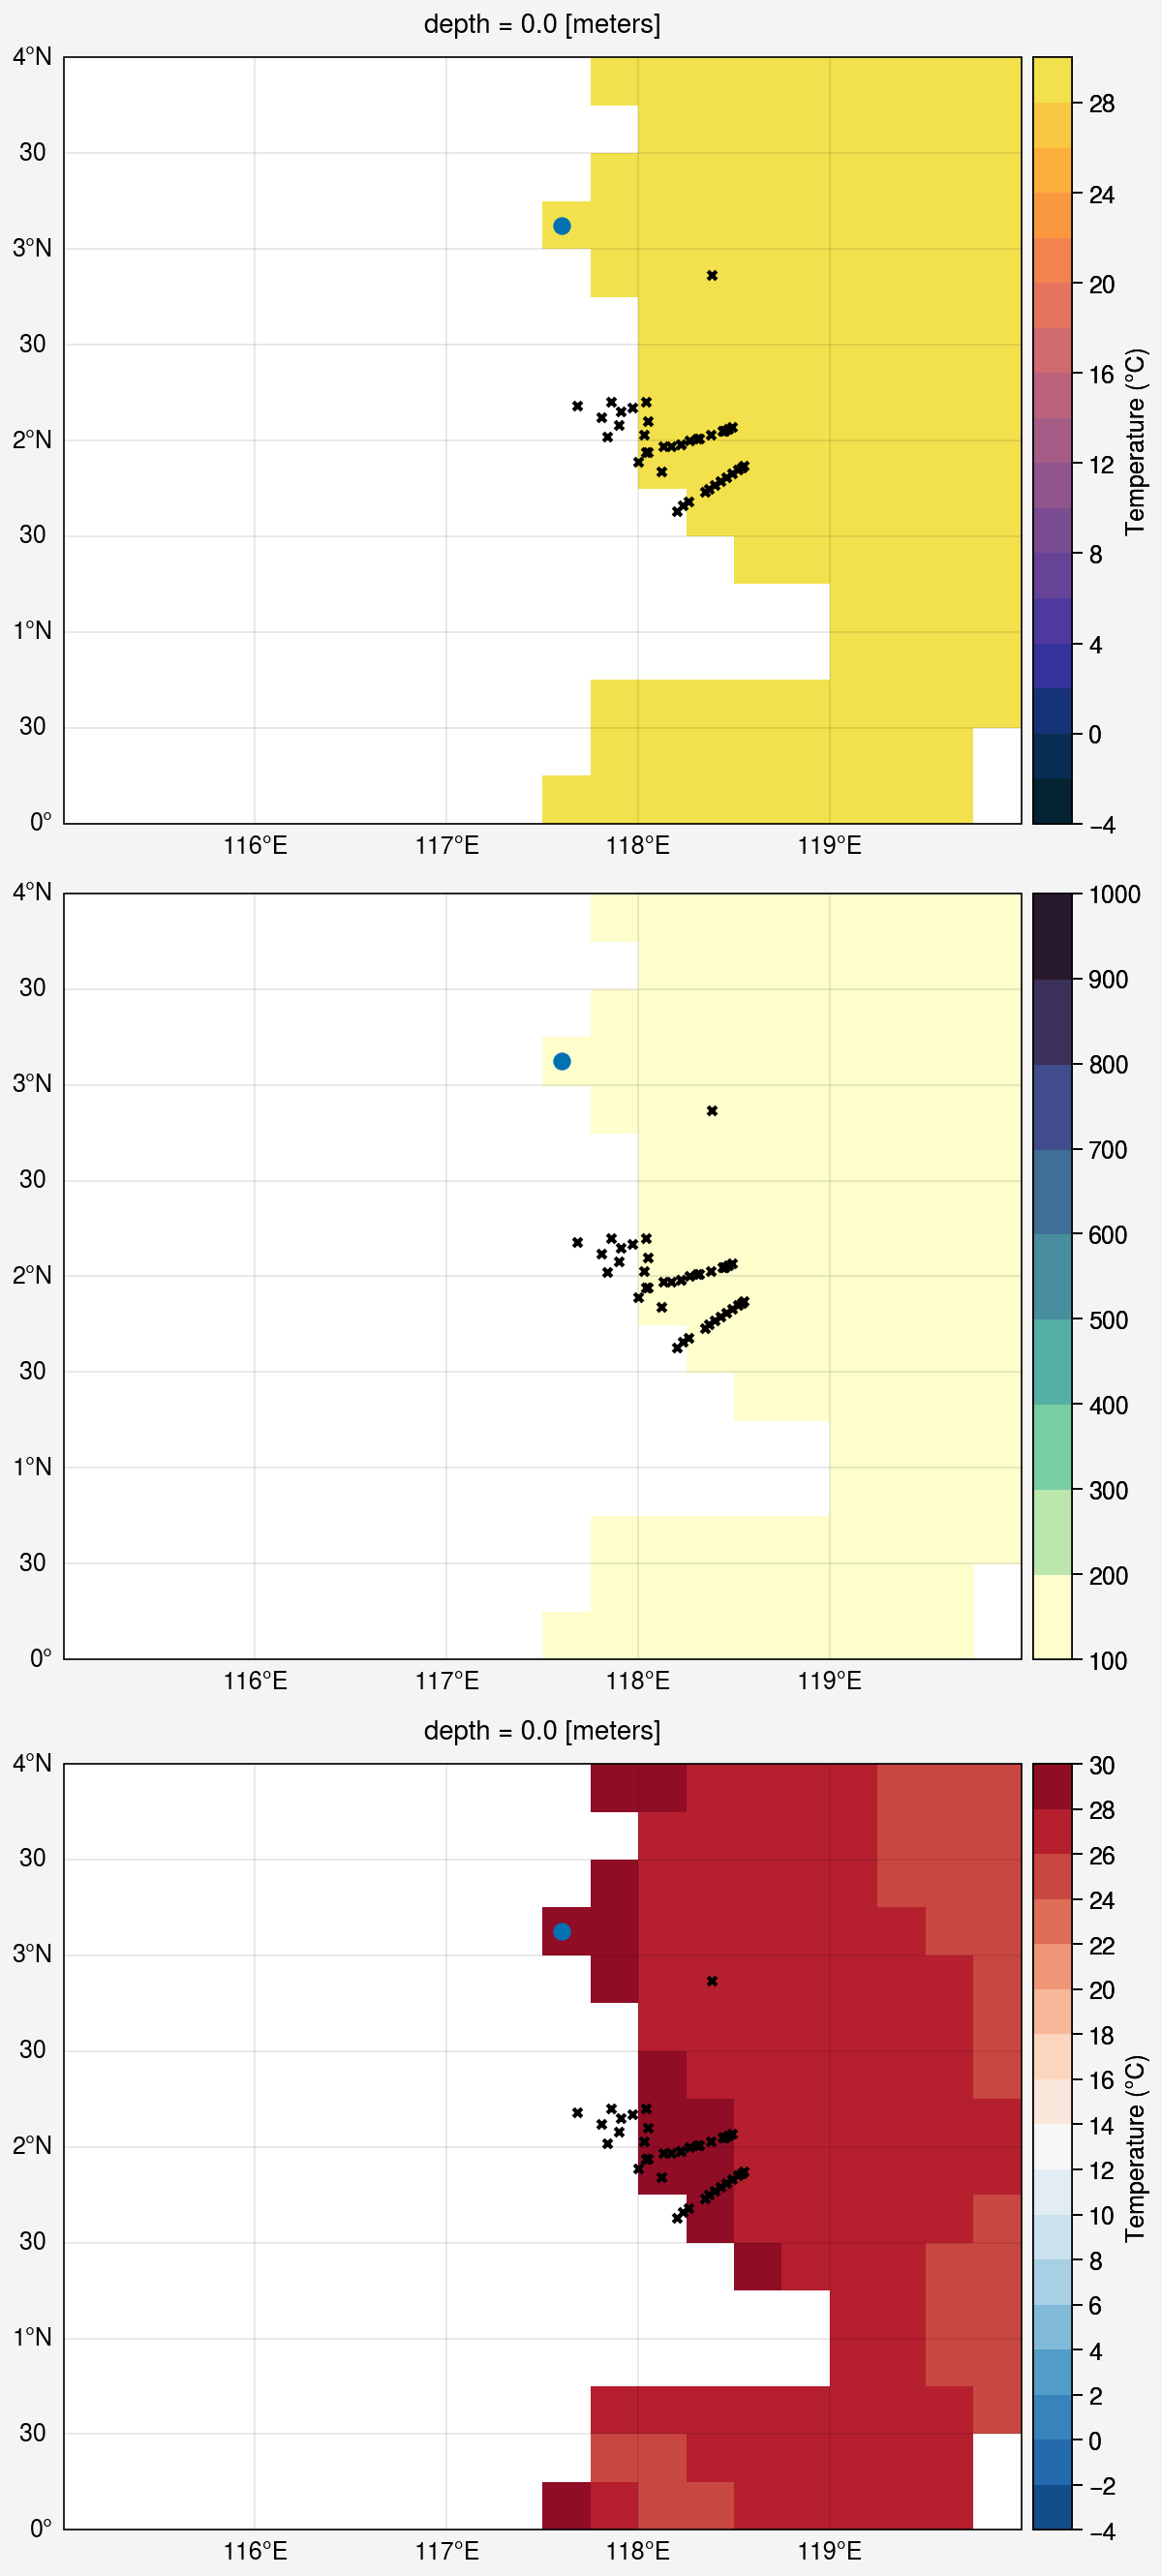

In [16]:
fig, axs = plot.subplots(nrows=3,proj='cyl',width=6)
axs.format(latlim=(0,4),lonlim=(115,120),
           latlabels=True,lonlabels=True,)

ax = axs[0]
aa = T_da.isel(depth=0)
m = aa.plot(ax=ax,
            levels=np.arange(-4,31,2),
            cmap='cmo.thermal',
            add_colorbar=False,
            )
ax.colorbar(m, loc='r', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,4),
            tickminor=False,
            )

ax = axs[1]

bb = thermoT_depth_da
m = bb.plot(ax=ax,
            # levels=np.arange(-4,31,2),
            cmap='cmo.deep',
            add_colorbar=False,
            )
ax.colorbar(m, loc='r', 
            # label='Temperature (\N{DEGREE SIGN}C)',
            # ticks=np.arange(-4,31,4),
            tickminor=False,
            )

ax = axs[2]
cc = thermocline_depthIntegral_T_da
m = cc.plot(ax=ax,
            levels=np.arange(-4,31,2),
            add_colorbar=False,
            )
ax.colorbar(m, loc='r', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,2),
            tickminor=False,
            )

axs.scatter(
    coretop_df2['Longitude'],coretop_df2['Latitude'],s=10,c='k',marker='x',label='Coretops'
)

axs.scatter(117.6,3.125)

In [17]:
T_da.sel(lon=117.5,lat=3.1,method='nearest').dropna('depth').integrate('depth')

<xarray.DataArray 't_an' ()>
array(0., dtype=float32)
Coordinates:
    lat      float32 3.125
    lon      float32 117.6

### 2.2.2 CMEMS Nitrate

CMEMS = Copernicus Marine Environmental Monitoring Service

- Nitrate - Mole concentration of nitrate in sea water 0.25deg x 0.25deg
- Unit: mmol/m3
- Link to data product website: https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_BGC_001_029/description

- Raw data: monthly climatology hindcasts from 1993-2022 (30 years)
- Processing: The climatology mean field of annual average were generated from 30-year montly climatologies using ncclimo function (https://nco.sourceforge.net/nco.html)

In [18]:
### NEMO nitrate data
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/Marine-Copernicus-Service/processed-files/Global-Biogeochemistry/climo-monthly/no3'
fname = r'mercatorfreebiorys2v4_global_mean_ANN_199301_202212_climo.nc'

nitrate_CMEMS_ds = xr.open_dataset(os.path.join(fpath,fname))
nitrate_CMEMS_ds = nitrate_CMEMS_ds.isel(time=0).drop('time')
nitrate_CMEMS_ds = nitrate_CMEMS_ds.rename({'latitude':'lat','longitude':'lon'})
nitrate_CMEMS_da = nitrate_CMEMS_ds.no3.load() ### convert mmol/L to umol/L to make it comparable to WOA data
nitrate_CMEMS_da

depth_coord = nitrate_CMEMS_da.depth
depth_coord = depth_coord - depth_coord[0]
nitrate_CMEMS_da = nitrate_CMEMS_da.assign_coords(depth=depth_coord)
nitrate_CMEMS_da

<xarray.DataArray 'no3' (depth: 75, lat: 681, lon: 1440)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [5.7781367, 5.779535 , 5.7808266, ..., 5.7733583, 5.775043 ,
         5.7766376],
        [5.720044 , 5.7206492, 5.721291 , ..., 5.718462 , 5.7189493,
         5.719477 ],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -80.0 -79.75 -79.5 -79.25 ... 89.25 89.5 89.75 90.0
  * depth    (depth) float32 0.0 1.05 2.162 ... 5.494e+03 5.698e+03 5.902e+03
Attributes:
    long_name:      Nitrate
    standard_name:  mole_concentration_of_nitrate_in_sea_water
    units:          mmol m-3
    unit_long:      millimoles of Nitrate per cubic meter
    valid_min:      0.0
    valid_max:      59.31268
    cell_methods:   time: mean

In [19]:
### regrid nitrate_CMESM to T_an grid
nitrate_CMEMS_da_regrid_ll = nitrate_CMEMS_da.interp(lat=T_da.lat,lon=T_da.lon,method='linear')
display(nitrate_CMEMS_da_regrid_ll)

nitrate_CMEMS_da_regrid_lld = nitrate_CMEMS_da.interp(lat=T_da.lat,lon=T_da.lon,depth=T_da.depth,method='linear')
nitrate_CMEMS_da_regrid_lld 

<xarray.DataArray 'no3' (depth: 75, lat: 720, lon: 1440)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [5.7811136, 5.7841377, 5.7870884, ..., 5.771783 , 5.774918 ,
               nan],
        [5.749591 , 5.750575 , 5.751523 , ..., 5.7464533, 5.7475266,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * depth    (depth) float32 0.0 1.05 2.162 ... 5.494e+03 5.698e+03 5.902e+03
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    long_name:      Nitrate
    standard_name:  mole_concentration_of_nitrate_in_sea_water
    units:          mmol m-3
    unit_long:      millimoles of Nitrate per cubic meter
    valid_min:      0.0
    valid_max:      59.31268
    cell_methods:   time: mean

<xarray.DataArray 'no3' (depth: 102, lat: 720, lon: 1440)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [5.7811136, 5.7841377, 5.7870884, ..., 5.771783 , 5.774918 ,
               nan],
        [5.749591 , 5.750575 , 5.751523 , ..., 5.7464533, 5.7475266,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Attributes:
    long_name:      Nitrate
    standard_name:  mole_concentration_of_nitrate_in_sea_water
    units:          mmol m-3
    unit_long:      millimoles of Nitrate per cubic meter
    valid_min:      0.0
    valid_max:      59.31268
    cell_methods:   time: mean

In [20]:
masked_nitrate_regrid_lld_da = nitrate_CMEMS_da_regrid_lld.where(nitrate_CMEMS_da_regrid_lld["depth"]<=thermoT_depth_da)
masked_tmp_grid = masked_nitrate_regrid_lld_da
len_notnull_values_along_depth = np.unique(masked_tmp_grid.notnull().sum('depth').values)
tmp_da = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                      dims=masked_tmp_grid.isel(depth=0).dims,
                      coords=masked_tmp_grid.isel(depth=0).coords
                      )
tmp_da2 = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                        dims=masked_tmp_grid.isel(depth=0).dims,
                        coords=masked_tmp_grid.isel(depth=0).coords
                        )
# Loop through the unique counts of non-NaN values along depth
for i in len_notnull_values_along_depth:
    if i == 0:
        continue  # Skip cases where no valid data is available
    # Select grid points where the non-NaN count equals `i`
    mask = masked_tmp_grid.notnull().sum('depth') == i
    
    if i == 1:
        # if only one valid depth slice, use the first depth slice
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
    else:
        # Calculate the integrated values for the valid depth slices
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .integrate('depth')
        )
        ### grab last value of nitrate
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .isel(depth=i-1)
        )
    # Update tmp_da with the calculated values at the same grid points
    tmp_da = tmp_da.where(~mask, other=cal_values)
    tmp_da2 = tmp_da2.where(~mask, other=cal_values2)

#### mask locations where there are more than 1 valid depth values
mask_below_surface = masked_tmp_grid.notnull().sum('depth') > 1
cal_values = tmp_da.where(mask_below_surface)/thermoT_depth_da.where(mask_below_surface)

# apply mask where all depth values are NaN
all_nan_mask = np.isnan(masked_tmp_grid).all('depth')
tmp_da = tmp_da.where(~all_nan_mask)
thermocline_depthIntegral_nitrate_da = tmp_da
thermocline_depthIntegral_nitrate_da = thermocline_depthIntegral_nitrate_da.where(~mask_below_surface, other=cal_values)
display(thermocline_depthIntegral_nitrate_da)

tmp_da2 = tmp_da2.where(~all_nan_mask)
thermocline_nitrate_da = tmp_da2
display(thermocline_nitrate_da)


<xarray.DataArray (lat: 720, lon: 1440)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [7.5698457, 7.572421 , 7.5749416, ..., 7.561945 , 7.5645914,
              nan],
       [7.498859 , 7.4996924, 7.500496 , ..., 7.496213 , 7.4971166,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 0.0

<xarray.DataArray (lat: 720, lon: 1440)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [9.325234, 9.326268, 9.32728 , ..., 9.322065, 9.323127,      nan],
       [9.300414, 9.300759, 9.301102, ..., 9.299388, 9.299727,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 1e+03

### 2.2.3 WOA23 Nitrate

In [21]:
### WOA23 nitrate data
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
fname = r'woa23_all_n00_01.nc'

nitrate_WOA23_da = xr.open_dataset(os.path.join(fpath2,fname),decode_times=False).n_an.load()
nitrate_WOA23_da

<xarray.DataArray 'n_an' (time: 1, depth: 102, lat: 180, lon: 360)>
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.5065072 , 0.5077519 , 0.50824255, ..., 0.49354407,
          0.49962154, 0.50394267],
         [0.5509077 , 0.552426  , 0.55362046, ..., 0.53350955,
          0.5418536 , 0.54766   ],
         [0.5734835 , 0.5734835 , 0.5734835 , ..., 0.5734835 ,
          0.5734835 , 0.5734835 ]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
...
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time     (time) float32 3.894e+03
Attributes:
    standard_name:  moles_of_nitrate_per_unit_mass_in_sea_water
    long_name:      Objectively analyzed mean fields for moles_of_nitrate_per...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          micromoles_per_kilogram

In [22]:
### calculate thermocline along depth dimension of T_da using min T gradient approach (depth with the fastest drop in T)
### calculate using diff method from xarray and divide by the diff of depth
sel_T_da = T_da_01
sliced_T_da = sel_T_da.sel(depth=slice(0,1100))
gradient = sliced_T_da.diff('depth')/sliced_T_da.depth.diff('depth')

### mask NaN values
gradient = abs(gradient.where(~np.isnan(sel_T_da)))

### fill NaN values with infinity to avoid error in argmin
gradient_filled = gradient.fillna(-np.inf)
maxabs_gradient_idx = gradient_filled.argmax('depth',skipna=True).astype(int)+1

### mask locations where all depth values are NaN
all_nan_mask = np.isnan(sliced_T_da).all('depth')

### mask maxabs_gradient_idx where all depth values are NaN
maxabs_gradient_idx = maxabs_gradient_idx.where(~all_nan_mask, drop=False)

# Flatten the lat-lon grid for advanced indexing
stacked = sliced_T_da.stack(grid=["lat", "lon"])

# Ensure maxabs_gradient_idx is an integer, replacing NaN with a valid placeholder index (e.g., 0)
valid_idx = maxabs_gradient_idx.fillna(0).astype(int)

# Use isel to index the depth dimension with the flattened indices
thermoT_01_depth_values = stacked["depth"].isel(depth=valid_idx.stack(grid=["lat", "lon"]))
thermoT_01_values = stacked.isel(depth=valid_idx.stack(grid=["lat", "lon"]))
# Mask locations where maxabs_gradient_idx was NaN
nan_mask = maxabs_gradient_idx.isnull()
thermoT_01_depth_values = thermoT_01_depth_values.where(~nan_mask.stack(grid=["lat", "lon"]))
thermoT_01_values = thermoT_01_values.where(~nan_mask.stack(grid=["lat", "lon"]))
# Unstack to return to the original lat-lon dimensions
thermoT_01_depth_da = thermoT_01_depth_values.unstack("grid")
thermoT_01_da = thermoT_01_values.unstack("grid")



In [23]:
masked_nitrate_WOA23 = nitrate_WOA23_da.where(nitrate_WOA23_da["depth"]<=thermoT_01_depth_da)
masked_tmp_grid = masked_nitrate_WOA23
len_notnull_values_along_depth = np.unique(masked_tmp_grid.notnull().sum('depth').values)
tmp_da = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                      dims=masked_tmp_grid.isel(depth=0).dims,
                      coords=masked_tmp_grid.isel(depth=0).coords
                      )
tmp_da2 = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                        dims=masked_tmp_grid.isel(depth=0).dims,
                        coords=masked_tmp_grid.isel(depth=0).coords
                        )
# Loop through the unique counts of non-NaN values along depth
for i in len_notnull_values_along_depth:
    if i == 0:
        continue  # Skip cases where no valid data is available
    # Select grid points where the non-NaN count equals `i`
    mask = masked_tmp_grid.notnull().sum('depth') == i
    
    if i == 1:
        # if only one valid depth slice, use the first depth slice
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
    else:
        # Calculate the integrated values for the valid depth slices
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .integrate('depth')
        )
        ### grab last value of nitrate
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .isel(depth=i-1)
        )
    # Update tmp_da with the calculated values at the same grid points
    tmp_da = tmp_da.where(~mask, other=cal_values)
    tmp_da2 = tmp_da2.where(~mask, other=cal_values2)

#### mask locations where there are more than 1 valid depth values
mask_below_surface = masked_tmp_grid.notnull().sum('depth') > 1
cal_values = tmp_da.where(mask_below_surface)/thermoT_01_depth_da.where(mask_below_surface)

# apply mask where all depth values are NaN
all_nan_mask = np.isnan(masked_tmp_grid).all('depth')
tmp_da = tmp_da.where(~all_nan_mask)
WOA23_thermocline_depthIntegral_nitrate_da = tmp_da
WOA23_thermocline_depthIntegral_nitrate_da = WOA23_thermocline_depthIntegral_nitrate_da.where(~mask_below_surface, other=cal_values)
display(WOA23_thermocline_depthIntegral_nitrate_da)
tmp_da2 = tmp_da2.where(~all_nan_mask)
WOA23_thermocline_nitrate_da = tmp_da2
display(WOA23_thermocline_nitrate_da)


<xarray.DataArray (time: 1, lat: 180, lon: 360)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [5.9040422, 5.9228544, 5.946482 , ..., 5.8460336, 5.8687625,
         5.88737  ],
        [5.67362  , 5.685511 , 5.6993546, ..., 5.6302495, 5.6478033,
         5.661916 ],
        [5.414655 , 5.414655 , 5.414655 , ..., 5.414655 , 5.414655 ,
         5.414655 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    depth    float32 0.0
  * time     (time) float32 3.894e+03

<xarray.DataArray (time: 1, lat: 180, lon: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [11.059551 , 11.109554 , 11.168578 , ..., 10.905602 ,
         10.963257 , 11.0125885],
        [10.045896 , 10.079221 , 10.116056 , ...,  9.940072 ,
          9.9796095, 10.013854 ],
        [ 8.903845 ,  8.903845 ,  8.903845 , ...,  8.903845 ,
          8.903845 ,  8.903845 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) float32 3.894e+03

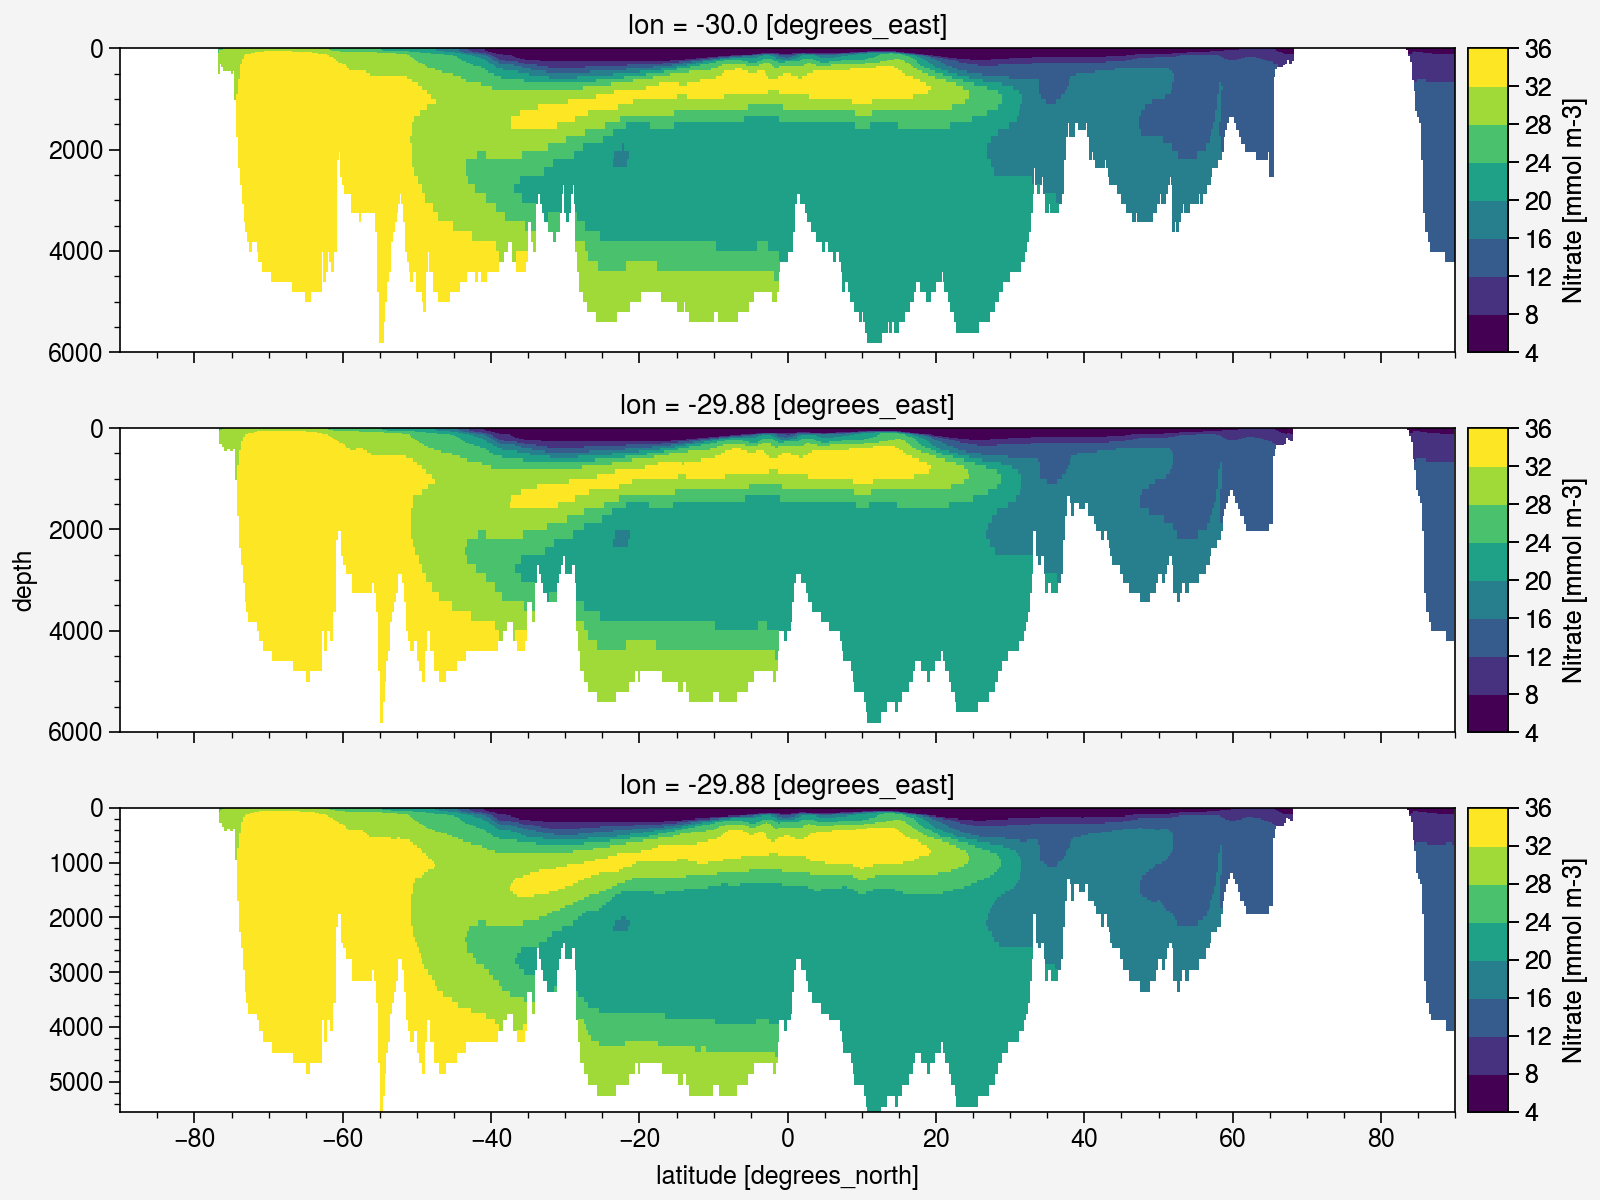

In [24]:
fig, axs = plot.subplots(nrows=3,figsize=(8,6))
sel_lon = -30
ax = axs[0]
nitrate_CMEMS_da.sel(lon=sel_lon,method='nearest').plot(ax=ax)

ax = axs[1]
nitrate_CMEMS_da_regrid_ll.sel(lon=sel_lon,method='nearest').plot(ax=ax)

ax = axs[2]
nitrate_CMEMS_da_regrid_lld.sel(lon=sel_lon,method='nearest').plot(ax=ax)

axs.format(
    yreverse=True,
)

In [25]:
thermocline_depthIntegral_nitrate_da = thermocline_depthIntegral_nitrate_da.rename('thermocl_depthIntg_nitrate')
thermocline_nitrate_da = thermocline_nitrate_da.rename('thermocl_nitrate')
WOA23_thermocline_depthIntegral_nitrate_da = WOA23_thermocline_depthIntegral_nitrate_da.rename('thermocl_depthIntg_nitrate')
WOA23_thermocline_nitrate_da = WOA23_thermocline_nitrate_da.rename('thermocl_nitrate')
thermocline_depthIntegral_T_da = thermocline_depthIntegral_T_da.rename('thermocl_depthIntg_T')
thermoT_depth_da = thermoT_depth_da.rename('thermocl_depth')
thermoT_da = thermoT_da.rename('thermocl_T')

In [26]:
# #### save all calculated dataarrays to netcdf
# fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/calculated-properties'

# fname = 'CMEMS_thermocline_nitrate_integral_011625.nc'
# thermocline_depthIntegral_nitrate_da.to_netcdf(os.path.join(fpath,fname))

# fname = 'CMEMS_thermocline_nitrate_011625.nc'
# thermocline_nitrate_da.to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_nitrate_integral_011625.nc'
# WOA23_thermocline_depthIntegral_nitrate_da.to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_nitrate_011625.nc'
# WOA23_thermocline_nitrate_da.to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_depthIntegral_T_011625.nc'
# thermocline_depthIntegral_T_da.to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_depth_011625.nc'
# thermoT_depth_da.to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_T_011625.nc'
# thermoT_da.to_netcdf(os.path.join(fpath,fname))

# 3. Pre-processing

## 3.0 Match gridded lat, lon, depth

In [27]:
coretop_uk_df.columns

Index(['core_name', 'core_type', 'sample_depth_start', 'sample_depth_end',
       'latitude', 'longitude', 'wdepth', 'UK37', 'include', 'reference_name',
       'reference_link', 'notes'],
      dtype='object')

In [28]:
mid_lat_array = T_da.lat.values
mid_lon_array = T_da.lon.values
depth_array = T_da.depth.values
coretop_df2['match_lat'] = [mid_lat_array[np.abs(mid_lat_array-row).argmin()] for row in coretop_df2['Latitude']]
coretop_df2['match_lon'] = [mid_lon_array[np.abs(mid_lon_array-row).argmin()] for row in coretop_df2['Longitude']]
coretop_df2['match_depth'] = [depth_array[np.abs(depth_array-row).argmin()] for row in coretop_df2['modernWaterDepth']]

coretop_uk_df['match_lat'] = [mid_lat_array[np.abs(mid_lat_array-row).argmin()] for row in coretop_uk_df['latitude']]
coretop_uk_df['match_lon'] = [mid_lon_array[np.abs(mid_lon_array-row).argmin()] for row in coretop_uk_df['longitude']]
coretop_uk_df['match_depth'] = [depth_array[np.abs(depth_array-row).argmin()] for row in coretop_uk_df['wdepth']]
coretop_uk_df

,core_name,core_type,sample_depth_start,sample_depth_end,latitude,longitude,wdepth,UK37,include,reference_name,reference_link,notes,match_lat,match_lon,match_depth
0,GeoB5844-2,GC,-999.0,-999.0,27.714,34.682,963.0,0.950,1,Arz2003 Leduc2010,http://dx.doi.org/10.1126/science.1080325 ht...,backcalculated from sst=26.8,27.625,34.625,950.0
1,SU81-18,PC,10.0,11.0,37.767,-10.183,3135.0,0.637,1,Bard2000 Leduc2010,http://dx.doi.org/10.1126/science.289.5483.132...,NaN,37.875,-10.125,3100.0
2,SO136-GC11,GC,-999.0,-999.0,-43.440,167.851,1556.0,0.539,1,Barrows2007 Leduc2010,http://dx.doi.org/10.1126/science.1145873 htt...,backcalculated from sst=15,-43.375,167.875,1550.0
3,GeoB15104-1,MC,0.0,2.0,40.800,27.720,606.0,0.617,1,Becker2015,http://dx.doi.org/10.1016/j.orggeochem.2015.04...,NaN,40.875,27.625,600.0
4,JR51-GC35,PC,-999.0,-999.0,66.999,-17.961,420.0,0.231,1,Bendle2007 Leduc2010,http://dx.doi.org/10.1177/0959683607073269 ht...,backcalculated from sst=4.6,66.875,-17.875,425.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,PS75/101-2,MC,0.0,1.0,-45.758,175.876,1773.0,0.324,1,Ho2012,http://dx.doi.org/10.1029/2012PA002317,NaN,-45.875,175.875,1750.0
1340,PS75/063-2,MC,0.0,1.0,-58.904,-135.629,4147.0,0.093,1,Ho2012,http://dx.doi.org/10.1029/2012PA002317,NaN,-58.875,-135.625,4100.0
1341,RS147-GC017,GC,1.0,2.0,-47.750,145.817,3300.0,0.383,1,Sikes2009,http://dx.doi.org/10.1029/2008PA001659,NaN,-47.875,145.875,3300.0
1342,RS147-GC07,GC,1.0,2.0,-45.150,146.283,3300.0,0.584,1,Sikes2009,http://dx.doi.org/10.1029/2008PA001659,NaN,-45.125,146.375,3300.0


## 3.1 Temperature and thermoclines

In [29]:
##### Calculated clines depth and integrated and weighted integral values
coretop_df2['SST'] = [np.atleast_1d(T_da.isel(depth=0).sel(lat=coretop_df2['Latitude'].iloc[i],lon=coretop_df2['Longitude'].iloc[i],
                               method='nearest').values)[0] for i in range(len(coretop_df2))]
coretop_df2['thermocline_depth'] = [np.atleast_1d(thermoT_depth_da.sel(lat=coretop_df2['Latitude'].iloc[i],lon=coretop_df2['Longitude'].iloc[i],
                                 method='nearest').values)[0] for i in range(len(coretop_df2))]
coretop_df2['thermocline_T'] = [np.atleast_1d(thermoT_da.sel(lat=coretop_df2['Latitude'].iloc[i],lon=coretop_df2['Longitude'].iloc[i],
                                 method='nearest').values)[0] for i in range(len(coretop_df2))]
coretop_df2['thermocline_T_depthIntegral'] = [np.atleast_1d(thermocline_depthIntegral_T_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                                lon=coretop_df2['Longitude'].iloc[i],
                                                                                method='nearest').values)[0] for i in range(len(coretop_df2))]
    
coretop_df2

,sampleID,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,fGDGT_0,...,methaneIndex,gdgtZeroOverZeroCren,QC_flag,match_lat,match_lon,match_depth,SST,thermocline_depth,thermocline_T,thermocline_T_depthIntegral
0,TEXAS_PSM_RR00002,KNR195-5 MC11,MC,6.0,8.0,-1.5327,-86.7852,2288.0,0.602873,0.330589,...,0.204131,0.330589,include,-1.625,-86.875,2300.0,23.591499,30.0,20.449209,22.447308
1,TEXAS_PSM_RR00005,KNR195-5 MC18,MC,4.0,6.0,-3.9690,-81.3100,1024.0,0.599447,0.282415,...,0.175419,0.282415,include,-3.875,-81.375,1000.0,21.894609,15.0,20.246809,21.175428
2,TEXAS_PSM_RR00007,KNR195-5 MC25,MC,5.0,7.0,-3.5830,-81.1650,381.0,0.617192,0.292011,...,0.196327,0.292011,include,-3.625,-81.125,375.0,22.924891,20.0,20.120491,21.640024
3,TEXAS_PSM_RR00008,KNR195-5 MC33,MC,3.0,5.0,-3.2237,-82.9142,2949.0,0.605147,0.309270,...,0.199117,0.309270,include,-3.125,-82.875,2900.0,21.708290,35.0,18.529690,20.469841
4,TEXAS_PSM_RR00009,KNR195-5 MC34,MC,4.0,6.0,-3.5975,-83.9632,3224.0,0.588670,0.344233,...,0.233462,0.344233,include,-3.625,-83.875,3200.0,22.364599,35.0,19.300900,21.233810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,TEXAS_PSM_RR02077,SY201710_LD-18,NaN,NaN,NaN,20.5700,113.8000,89.0,0.595556,0.236000,...,0.255236,0.236000,include,20.625,113.875,90.0,25.813690,65.0,22.406591,24.507648
2018,TEXAS_PSM_RR02078,DO201207-08_QD11a,NaN,NaN,NaN,20.7000,113.3700,81.0,0.512500,0.281000,...,0.201669,0.281000,include,20.625,113.375,80.0,25.718901,65.0,22.375799,24.396751
2019,TEXAS_PSM_RR02079,DO201207-08_QD41,NaN,NaN,NaN,20.1400,112.0600,87.0,0.585859,0.236000,...,0.225131,0.236000,include,20.125,112.125,85.0,25.984491,35.0,24.453291,25.438898
2020,TEXAS_PSM_RR02080,DO201207-08_E503,NaN,NaN,NaN,19.2000,112.2900,189.0,0.651376,0.237000,...,0.229358,0.237000,include,19.125,112.375,200.0,26.653790,55.0,23.470810,25.555941


## 3.2 Nitrate concentrations

In [31]:
### calculate integrated nitrate values to the thermocline depth
coretop_df2['SSN'] = [nitrate_CMEMS_da_regrid_lld.isel(depth=0).sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                    lon=coretop_df2['Longitude'].iloc[i],
                                                                    method='nearest').values for i in range(len(coretop_df2))]

coretop_df2['thermocline_nitrate'] = [thermocline_nitrate_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                lon=coretop_df2['Longitude'].iloc[i],
                                                                method='nearest').values for i in range(len(coretop_df2))]
coretop_df2['thermocline_nitrate_depthIntegral'] = [thermocline_depthIntegral_nitrate_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                                            lon=coretop_df2['Longitude'].iloc[i],
                                                                                            method='nearest').values for i in range(len(coretop_df2))]

coretop_df2

,sampleID,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,fGDGT_0,...,match_lat,match_lon,match_depth,SST,thermocline_depth,thermocline_T,thermocline_T_depthIntegral,SSN,thermocline_nitrate,thermocline_nitrate_depthIntegral
0,TEXAS_PSM_RR00002,KNR195-5 MC11,MC,6.0,8.0,-1.5327,-86.7852,2288.0,0.602873,0.330589,...,-1.625,-86.875,2300.0,23.591499,30.0,20.449209,22.447308,4.0946407,9.728418,5.9342237
1,TEXAS_PSM_RR00005,KNR195-5 MC18,MC,4.0,6.0,-3.9690,-81.3100,1024.0,0.599447,0.282415,...,-3.875,-81.375,1000.0,21.894609,15.0,20.246809,21.175428,4.3262396,6.4624686,4.9695497
2,TEXAS_PSM_RR00007,KNR195-5 MC25,MC,5.0,7.0,-3.5830,-81.1650,381.0,0.617192,0.292011,...,-3.625,-81.125,375.0,22.924891,20.0,20.120491,21.640024,3.5177152,7.6722565,4.8409147
3,TEXAS_PSM_RR00008,KNR195-5 MC33,MC,3.0,5.0,-3.2237,-82.9142,2949.0,0.605147,0.309270,...,-3.125,-82.875,2900.0,21.708290,35.0,18.529690,20.469841,4.1205397,11.105642,6.493748
4,TEXAS_PSM_RR00009,KNR195-5 MC34,MC,4.0,6.0,-3.5975,-83.9632,3224.0,0.588670,0.344233,...,-3.625,-83.875,3200.0,22.364599,35.0,19.300900,21.233810,5.059356,10.533526,6.70845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,TEXAS_PSM_RR02077,SY201710_LD-18,NaN,NaN,NaN,20.5700,113.8000,89.0,0.595556,0.236000,...,20.625,113.875,90.0,25.813690,65.0,22.406591,24.507648,0.1600422,0.9086927,0.1701051
2018,TEXAS_PSM_RR02078,DO201207-08_QD11a,NaN,NaN,NaN,20.7000,113.3700,81.0,0.512500,0.281000,...,20.625,113.375,80.0,25.718901,65.0,22.375799,24.396751,0.17522672,1.1108936,0.25876188
2019,TEXAS_PSM_RR02079,DO201207-08_QD41,NaN,NaN,NaN,20.1400,112.0600,87.0,0.585859,0.236000,...,20.125,112.125,85.0,25.984491,35.0,24.453291,25.438898,0.17859066,0.058803815,0.10573725
2020,TEXAS_PSM_RR02080,DO201207-08_E503,NaN,NaN,NaN,19.2000,112.2900,189.0,0.651376,0.237000,...,19.125,112.375,200.0,26.653790,55.0,23.470810,25.555941,0.12250069,0.17908919,0.06484472


In [32]:
### calculate integrated nitrate values to the thermocline depth
coretop_df2['WOA23_SSN'] = [nitrate_WOA23_da.isel(depth=0).sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                lon=coretop_df2['Longitude'].iloc[i],
                                                                method='nearest').values[0] for i in range(len(coretop_df2))]
coretop_df2['WOA23_thermocline_nitrate'] = [WOA23_thermocline_nitrate_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                            lon=coretop_df2['Longitude'].iloc[i],
                                                                            method='nearest').values[0] for i in range(len(coretop_df2))]
coretop_df2['WOA23_thermocline_nitrate_depthIntegral'] = [WOA23_thermocline_depthIntegral_nitrate_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                                                        lon=coretop_df2['Longitude'].iloc[i],
                                                                                                        method='nearest').values[0] for i in range(len(coretop_df2))]

coretop_df2

,sampleID,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,fGDGT_0,...,SST,thermocline_depth,thermocline_T,thermocline_T_depthIntegral,SSN,thermocline_nitrate,thermocline_nitrate_depthIntegral,WOA23_SSN,WOA23_thermocline_nitrate,WOA23_thermocline_nitrate_depthIntegral
0,TEXAS_PSM_RR00002,KNR195-5 MC11,MC,6.0,8.0,-1.5327,-86.7852,2288.0,0.602873,0.330589,...,23.591499,30.0,20.449209,22.447308,4.0946407,9.728418,5.9342237,5.557864,10.865924,7.603764
1,TEXAS_PSM_RR00005,KNR195-5 MC18,MC,4.0,6.0,-3.9690,-81.3100,1024.0,0.599447,0.282415,...,21.894609,15.0,20.246809,21.175428,4.3262396,6.4624686,4.9695497,6.466127,9.033489,7.690656
2,TEXAS_PSM_RR00007,KNR195-5 MC25,MC,5.0,7.0,-3.5830,-81.1650,381.0,0.617192,0.292011,...,22.924891,20.0,20.120491,21.640024,3.5177152,7.6722565,4.8409147,6.466127,9.033489,7.690656
3,TEXAS_PSM_RR00008,KNR195-5 MC33,MC,3.0,5.0,-3.2237,-82.9142,2949.0,0.605147,0.309270,...,21.708290,35.0,18.529690,20.469841,4.1205397,11.105642,6.493748,6.289342,12.159968,8.703465
4,TEXAS_PSM_RR00009,KNR195-5 MC34,MC,4.0,6.0,-3.5975,-83.9632,3224.0,0.588670,0.344233,...,22.364599,35.0,19.300900,21.233810,5.059356,10.533526,6.70845,6.482422,12.270123,8.719608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,TEXAS_PSM_RR02077,SY201710_LD-18,NaN,NaN,NaN,20.5700,113.8000,89.0,0.595556,0.236000,...,25.813690,65.0,22.406591,24.507648,0.1600422,0.9086927,0.1701051,0.536171,1.967975,0.827195
2018,TEXAS_PSM_RR02078,DO201207-08_QD11a,NaN,NaN,NaN,20.7000,113.3700,81.0,0.512500,0.281000,...,25.718901,65.0,22.375799,24.396751,0.17522672,1.1108936,0.25876188,0.536171,1.967975,0.827195
2019,TEXAS_PSM_RR02079,DO201207-08_QD41,NaN,NaN,NaN,20.1400,112.0600,87.0,0.585859,0.236000,...,25.984491,35.0,24.453291,25.438898,0.17859066,0.058803815,0.10573725,0.515824,1.079724,0.563984
2020,TEXAS_PSM_RR02080,DO201207-08_E503,NaN,NaN,NaN,19.2000,112.2900,189.0,0.651376,0.237000,...,26.653790,55.0,23.470810,25.555941,0.12250069,0.17908919,0.06484472,0.547781,1.573383,0.846152


## 3.3 Hand-labelling region name

In [33]:
##### Load spreadsheet with manually-assigned region names for coretops
fpath = os.path.join(local_github_path,'spreadsheets')
fname = 'manual_regionName_assignment_010425'
manual_regionName_df = pd.read_excel(os.path.join(fpath,fname+'.xlsx'),sheet_name='master_regionName')
manual_regionName_df = manual_regionName_df.rename(columns={'Sample ID':'sampleID',
                                                            'region_description':'regionName'})

coretop_df_full = pd.concat([coretop_df2.set_index('sampleID'),
                             manual_regionName_df.set_index('sampleID')],axis=1).reset_index(drop=False).dropna(subset=['core_name'])
coretop_df_full = coretop_df_full.loc[:,~coretop_df_full.columns.duplicated()]
coretop_df_full

,sampleID,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,fGDGT_0,...,thermocline_T,thermocline_T_depthIntegral,SSN,thermocline_nitrate,thermocline_nitrate_depthIntegral,WOA23_SSN,WOA23_thermocline_nitrate,WOA23_thermocline_nitrate_depthIntegral,region_ID,regionName
0,TEXAS_PSM_RR00002,KNR195-5 MC11,MC,6.0,8.0,-1.5327,-86.7852,2288.0,0.602873,0.330589,...,20.449209,22.447308,4.0946407,9.728418,5.9342237,5.557864,10.865924,7.603764,10.0,East Equatorial Pacific
1,TEXAS_PSM_RR00005,KNR195-5 MC18,MC,4.0,6.0,-3.9690,-81.3100,1024.0,0.599447,0.282415,...,20.246809,21.175428,4.3262396,6.4624686,4.9695497,6.466127,9.033489,7.690656,10.0,East Equatorial Pacific
2,TEXAS_PSM_RR00007,KNR195-5 MC25,MC,5.0,7.0,-3.5830,-81.1650,381.0,0.617192,0.292011,...,20.120491,21.640024,3.5177152,7.6722565,4.8409147,6.466127,9.033489,7.690656,10.0,East Equatorial Pacific
3,TEXAS_PSM_RR00008,KNR195-5 MC33,MC,3.0,5.0,-3.2237,-82.9142,2949.0,0.605147,0.309270,...,18.529690,20.469841,4.1205397,11.105642,6.493748,6.289342,12.159968,8.703465,10.0,East Equatorial Pacific
4,TEXAS_PSM_RR00009,KNR195-5 MC34,MC,4.0,6.0,-3.5975,-83.9632,3224.0,0.588670,0.344233,...,19.300900,21.233810,5.059356,10.533526,6.70845,6.482422,12.270123,8.719608,10.0,East Equatorial Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,TEXAS_PSM_RR02077,SY201710_LD-18,NaN,NaN,NaN,20.5700,113.8000,89.0,0.595556,0.236000,...,22.406591,24.507648,0.1600422,0.9086927,0.1701051,0.536171,1.967975,0.827195,38.0,South China Sea
2018,TEXAS_PSM_RR02078,DO201207-08_QD11a,NaN,NaN,NaN,20.7000,113.3700,81.0,0.512500,0.281000,...,22.375799,24.396751,0.17522672,1.1108936,0.25876188,0.536171,1.967975,0.827195,38.0,South China Sea
2019,TEXAS_PSM_RR02079,DO201207-08_QD41,NaN,NaN,NaN,20.1400,112.0600,87.0,0.585859,0.236000,...,24.453291,25.438898,0.17859066,0.058803815,0.10573725,0.515824,1.079724,0.563984,38.0,South China Sea
2020,TEXAS_PSM_RR02080,DO201207-08_E503,NaN,NaN,NaN,19.2000,112.2900,189.0,0.651376,0.237000,...,23.470810,25.555941,0.12250069,0.17908919,0.06484472,0.547781,1.573383,0.846152,38.0,South China Sea


In [34]:
import matplotlib.colors as mcolors
##### concatenate three colormaps

colors1 = plot.get_colors('tab10')
colors2 = plot.get_colors('tab20b')
colors3 = plot.get_colors('538')
colors4 = plot.get_colors('tab20c')
colors5 = plot.get_colors('bmh')

combined_cmap = np.concatenate((colors1,colors2,colors3,colors4,colors5))
extended_cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap',combined_cmap)
#########
region_list_full = coretop_df_full['regionName'].unique()
color_list_full = plot.get_colors(extended_cmap,len(region_list_full))

region_color_dict_full = dict(zip(region_list_full,color_list_full))
region_color_dict_full

region_color_dict_full_rgb = {k:mpl.colors.to_rgba(v) for k,v in region_color_dict_full.items()}
region_color_dict_full_rgb

{'East Equatorial Pacific': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765,
  1.0),
 'Mozambique Channel': (0.984313725490196,
  0.5019607843137255,
  0.058823529411764705,
  1.0),
 'Pacific-Southern Ocean': (0.3686274509803922,
  0.48627450980392156,
  0.16862745098039217,
  1.0),
 'Tasman-Antarctica 140E Transect': (0.6901960784313725,
  0.29411764705882354,
  0.49019607843137253,
  1.0),
 'NZ-SW Pacific': (0.5607843137254902,
  0.36470588235294116,
  0.47843137254901963,
  1.0),
 'Equatorial Pacific': (0.8431372549019608,
  0.4470588235294118,
  0.6980392156862745,
  1.0),
 'West Equatorial Pacific': (0.5294117647058824,
  0.5333333333333333,
  0.4470588235294118,
  1.0),
 'Tonga-Tropical South Pacific': (0.47058823529411764,
  0.7411764705882353,
  0.4117647058823529,
  1.0),
 'South China Sea': (0.14901960784313725,
  0.5215686274509804,
  0.6666666666666666,
  1.0),
 'Chilean Offshore': (0.29411764705882354,
  0.30196078431372547,
  0.592156862745098,
  1.0),
 '

## 3.4 Additional indices

In [35]:
### additional indices

coretop_df_full['TEX_RI_zhang16'] = (-0.77*coretop_df_full['TEX86']
                                )+(3.32*coretop_df_full['TEX86']**2
                                   )+(1.59)
coretop_df_full['deltaRI_zhang16'] = coretop_df_full['TEX_RI_zhang16']-coretop_df_full['RI_zhang16']



### Re-evaluate TEX-RI relationship

Text(0.05, 0.9, '$\\rho$=0.85, p=0.00 (linear-new)')

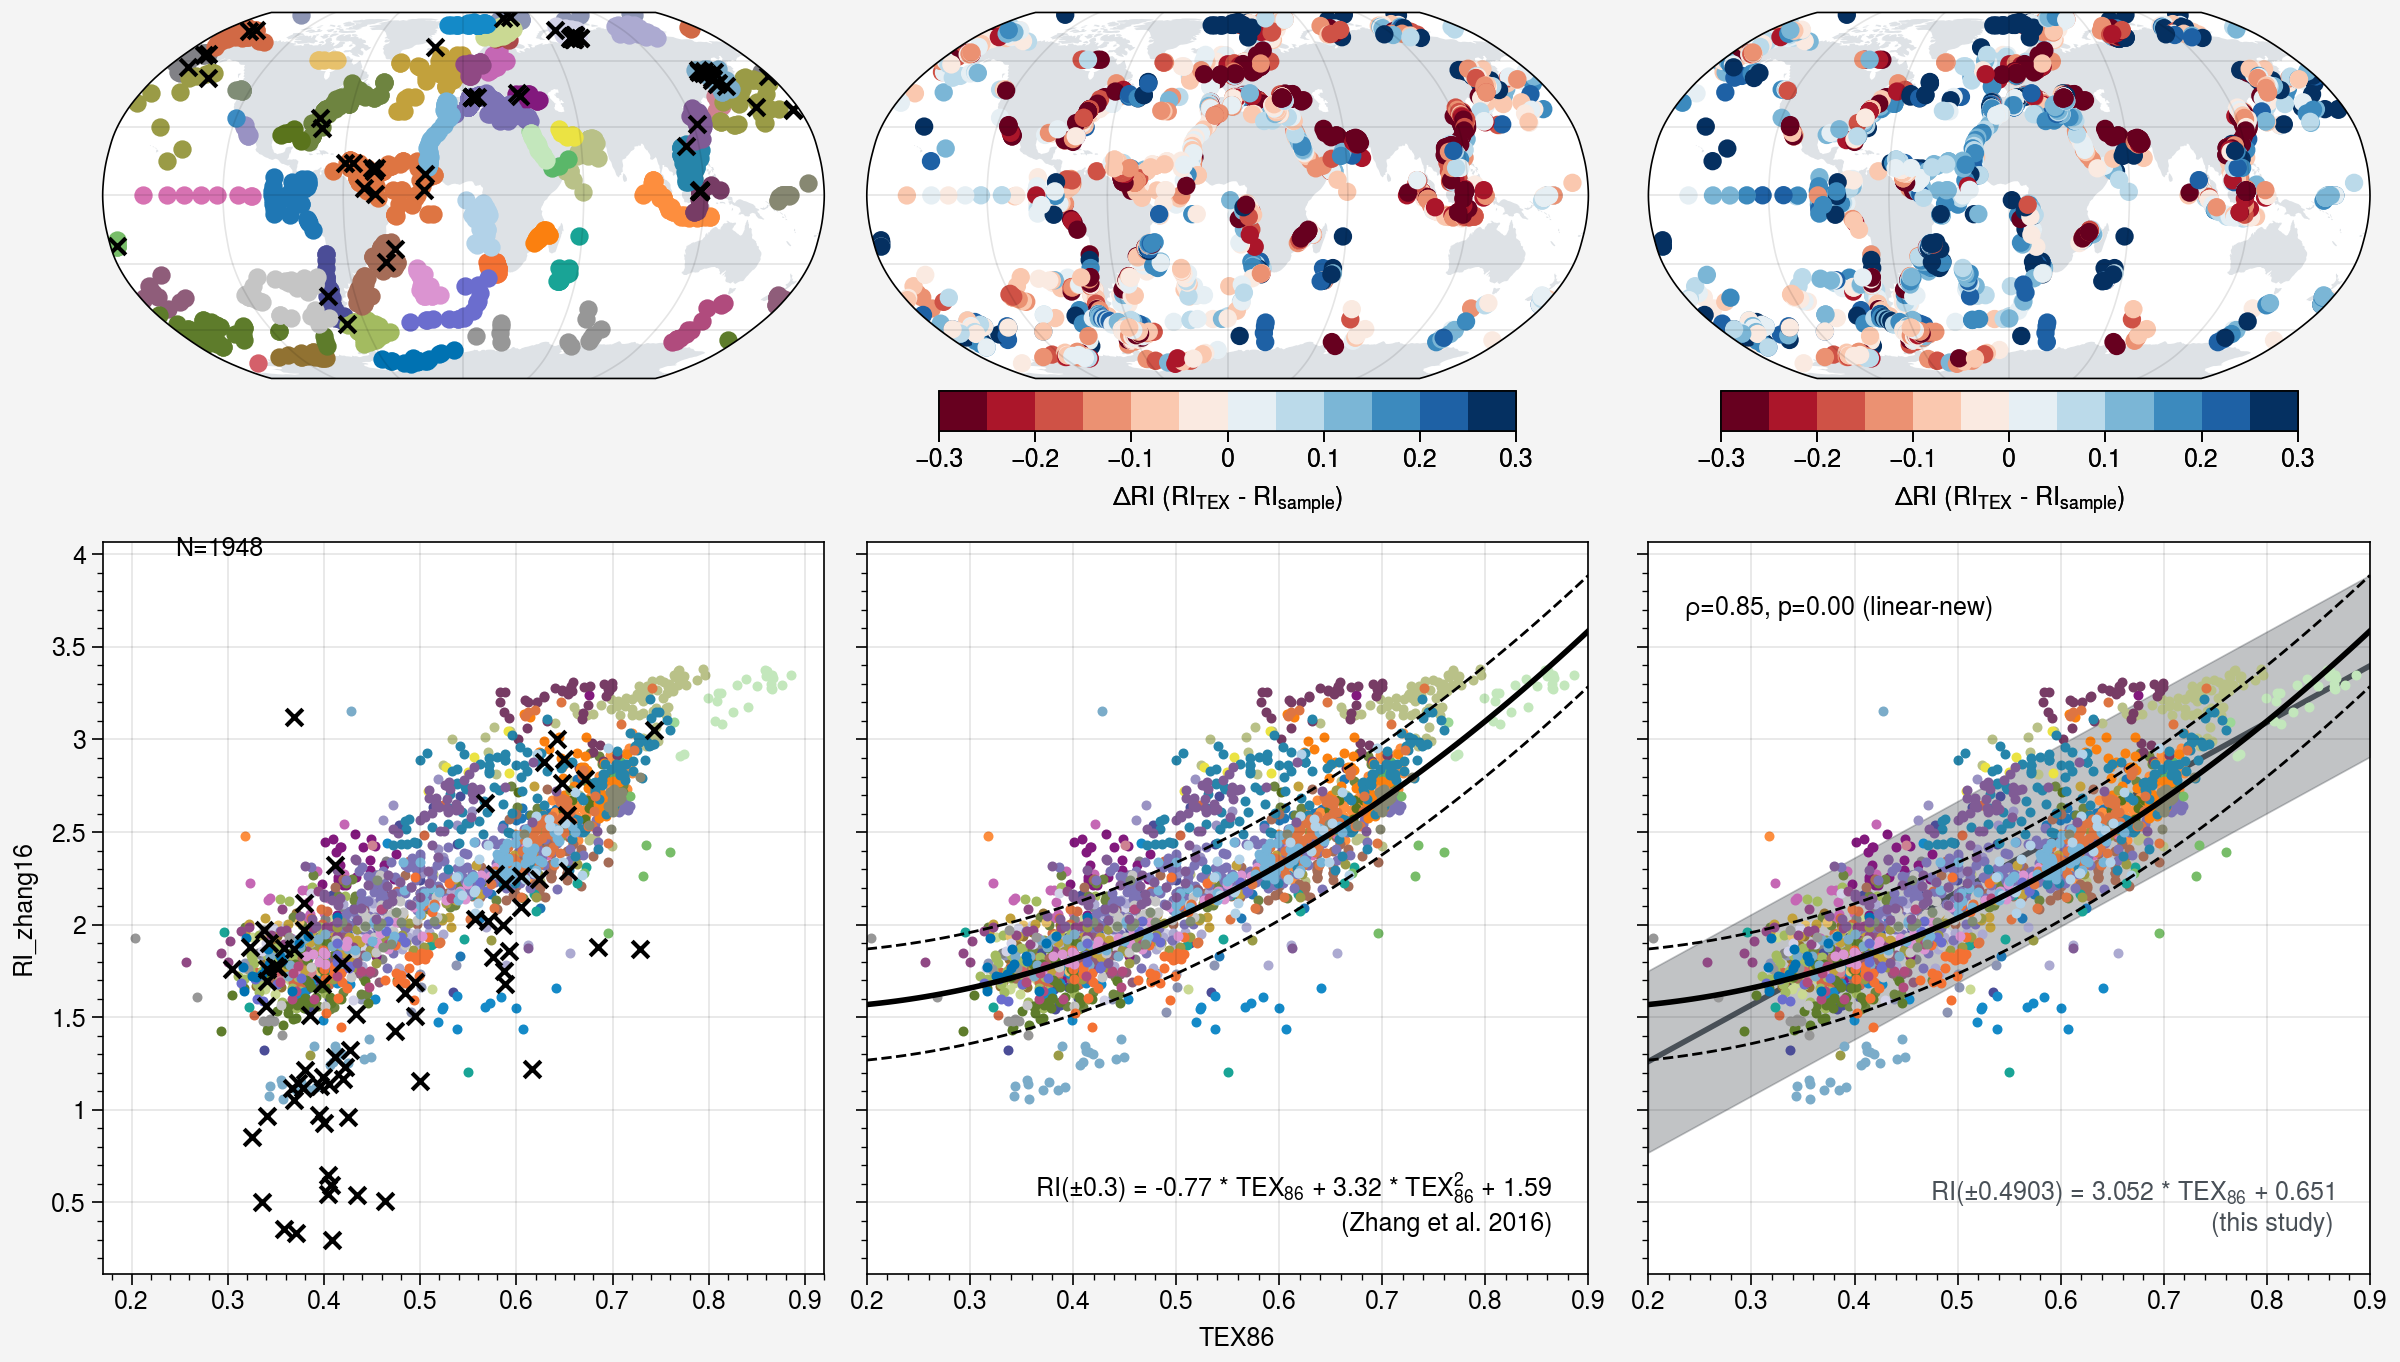

In [36]:
from scipy.stats import t

fig, axs = plot.subplots(width=12,
                         ncols=3,
                         nrows=2,
                         proj=('robin','robin','robin',None),
                         hratios=[1,2])
axs[0,:].format(
    land=True,landcolor='gray3',landzorder=0
)

plot_data = coretop_df_full[coretop_df_full['QC_flag']=='include']
plot_data_exclude = coretop_df_full[coretop_df_full['QC_flag']=='exclude']

m = axs[0,1].scatter(plot_data['Longitude'],plot_data['Latitude'],
               c=plot_data['deltaRI_zhang16'],
               levels=np.arange(-0.3,0.31,0.05),
               cmap='RdBu',
)
axs[0,1].colorbar(m,label='$\Delta$RI (RI$_{TEX}$ - RI$_{sample}$)',loc='b',length=0.8)

grouped = plot_data.groupby('regionName')
for region, group in grouped:
    axs[0,0].scatter(group['Longitude'],group['Latitude'],
                     c=region_color_dict_full.get(region),
                     label=region)
    axs[1,:].scatter(group['TEX86'],group['RI_zhang16'],
                   m='.',
                   c=region_color_dict_full.get(region),
                   label=region)

axs[0,0].scatter(plot_data_exclude['Longitude'],plot_data_exclude['Latitude'],
               m='x',c='k',
               label='excluded data')
axs[1,0].scatter(plot_data_exclude['TEX86'],plot_data_exclude['RI_zhang16'],
               m='x',c='k',
               label='excluded data')

data_len = len(plot_data)
axs[1,0].text(0.10,0.98,f'N={data_len}',transform=axs[1,0].transAxes)

### Zhang 2016 TEX-RI relationship
TEX_sample = np.linspace(0.2,0.9,100)
RI_sample = (-0.77*TEX_sample)+(3.32*TEX_sample**2)+1.59
RI_sample_upper = RI_sample + 0.3
RI_sample_lower = RI_sample - 0.3


axs[1,1:].plot(TEX_sample,RI_sample,c='k',lw=2,label='Zhang et al. 2016')
axs[1,1:].plot(TEX_sample,RI_sample_upper,c='k',ls='--',lw=1)
axs[1,1:].plot(TEX_sample,RI_sample_lower,c='k',ls='--',lw=1)

### write out equation
## Zhang et al. 2016
axs[1,1].text(0.95,0.05,'RI(±0.3) = -0.77 * TEX$_{86}$ + 3.32 * TEX$_{86}^2$ + 1.59\n(Zhang et al. 2016)',
            transform=axs[1,1].transAxes,
            ha='right',va='bottom')

#### OLS regression between TEX86 and RI_zhang16 for plot_data
ols = LinearRegression()
XX = plot_data['TEX86'].values.reshape(-1,1)
yy = plot_data['RI_zhang16']
ols.fit(XX,yy)
slope = ols.coef_[0]
intercept = ols.intercept_
RI_sample_ols = ols.predict(TEX_sample.reshape(-1,1))
axs[1,2].plot(TEX_sample,RI_sample_ols,c='gray7',lw=2,label='Linear (this study)',zorder=0)

#predict new RI for coretop_df_full
coretop_df_full['TEX_RI_new'] = ols.predict(coretop_df_full['TEX86'].values.reshape(-1,1))
coretop_df_full['deltaRI_new'] = coretop_df_full['TEX_RI_new']-coretop_df_full['RI_zhang16']

### plot on map
m2 = axs[0,2].scatter(coretop_df_full['Longitude'],coretop_df_full['Latitude'],
                c=coretop_df_full['deltaRI_new'],
                levels=np.arange(-0.3,0.31,0.05),
                cmap='RdBu',
    )
axs[0,2].colorbar(m2,label='$\Delta$RI (RI$_{TEX}$ - RI$_{sample}$)',loc='b',length=0.8)
### write out equation
## this study
axs[1,2].text(0.95,0.05,f'RI(±0.4903) = {slope:.3f}'+' * TEX$_{86}$ + '+f'{intercept:.3f}\n(this study)',
            transform=axs[1,2].transAxes,
            c='gray7',
            ha='right',va='bottom')

### 95% confidence interval
y_pred = ols.predict(plot_data['TEX86'].values.reshape(-1,1))
residuals = yy-y_pred
sse = np.sum(residuals**2)
n = len(plot_data)
p = XX.shape[1]
dof = n-p-1
mse = sse/dof
se = np.sqrt(mse)

### calculate critical t value
alpha = 0.05
t_value = t.ppf(1-alpha/2,dof)

### calculate confidence interval
lower_bound = RI_sample_ols - t_value*se
upper_bound = RI_sample_ols + t_value*se
axs[1,2].fill_between(TEX_sample,lower_bound,upper_bound,color='gray8',alpha=0.3,zorder=0)

### Spearman rho and p-value
rho,pval = scipy.stats.spearmanr(XX,yy)
axs[1,2].text(0.05,0.9,f'$\\rho$={rho:.2f}, p={pval:.2f} (linear-new)',
            transform=axs[1,2].transAxes)


### Calculate new deltaRI based on the revised TEX-RI relationship

- Create "QC_flag2" column by adding deltaRI_new condition

In [37]:
coretop_df_full['QC_flag2'] = np.nan
for i in range(len(coretop_df_full)):
    if coretop_df_full['QC_flag'].iloc[i]=='include':
        if abs(coretop_df_full['deltaRI_new'].iloc[i])<0.4903:
            coretop_df_full['QC_flag2'].iloc[i] = 'include'
        else:
            coretop_df_full['QC_flag2'].iloc[i] = 'exclude'
    else:
        coretop_df_full['QC_flag2'].iloc[i] = 'exclude'

In [39]:
fpath = os.path.join(local_github_path,'spreadsheets')
fname = 'coretop_df_full_011525_tmp'
coretop_df_full.to_csv(os.path.join(fpath,fname+'.csv'),index=False)


# 4. Gridded archaeal gene counts and ammonia oxidation rates

In [40]:
fpath = fr'{local_github_path}/spreadsheets/'
fname = r'Weiyi23_EarthSystSciData_nitrification_database.xlsx'

global_AOA_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='ammonia oxidizer')
global_AOA_df = global_AOA_df.rename(
    columns={
        'Depth (m)': 'Depth',
        'shallow clade AOA (copies L-1)': 'shallow_clade_AOA_copiesL', 
        'deep clade AOA (copies L-1)': 'deep_clade_AOA_copiesL',
        'total AOA (copies L-1)': 'total_AOA_copiesL', 
        'Thaumarchaeota 16S rRNA (copies L-1)': 'Thaum_16S_rRNA_copiesL',
        ' βAOB (copies L-1)': 'beta_AOB_copiesL', 
        'shallow clade AOA transcript (copies L-1)': 'shallow_clade_AOA_transcript_copiesL',
        'deep clade AOA transcript (copies L-1)': 'deep_clade_AOA_transcript_copiesL',
        'total AOA transcript (copies L-1)': 'total_AOA_transcript_copiesL', 
        ' βAOB transcript (copies L-1)': 'beta_AOB_transcript_copiesL',
        'PAR (μmol Einstein m-2 s-1)': 'PAR', 
        'Light level (%)': 'light_level', 
        'Temperature (°C)': 'insituT',
        'Salinity (psu)': 'insituS', 
        'Potential density (kg m-3)': 'insituSigmaT', 
        'Ammonium+ammonia (μM)': 'NH4_uM',
        'Nitrite (μM)': 'NO2_uM', 
        'Nitrate (μM)': 'NO3_uM', 
        'O2 (μM)': 'insituOxy'}
    )
global_AOA_df = global_AOA_df.replace(
    {'NM':np.nan,
     'BDL':np.nan,
     'NM ':np.nan}
)

global_AOA_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2249 entries, 0 to 2248
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Data source                           2249 non-null   object 
 1   data_source                           2249 non-null   object 
 2   Date                                  2249 non-null   object 
 3   Latitude                              2249 non-null   float64
 4   Longitude                             2249 non-null   float64
 5   Depth                                 2247 non-null   float64
 6   shallow_clade_AOA_copiesL             1220 non-null   float64
 7   deep_clade_AOA_copiesL                1099 non-null   float64
 8   total_AOA_copiesL                     1906 non-null   float64
 9   Thaum_16S_rRNA_copiesL                1132 non-null   float64
 10  beta_AOB_copiesL                      858 non-null    float64
 11  shallow_clade_AOA

In [41]:
global_AOM_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='volumetric ammonia oxidation')
global_AOM_df = global_AOM_df.rename(
    columns={
        'Depth (m)':'Depth',
        'Rate (nmol N L-1 d-1)':'ammoniaOxidationRate', 
        'Standard deviation of rate (nmol N L-1 d-1)':'AOR_std',
        'PAR (μmol Einstein m-2 s-1)':'PAR',
        'Light level (%)':'light_level',
        'Temperature (°C)':'insituT',
        'Salinity (psu)':'insituS',
        'Potential density (kg m-3)':'insituSigmaT',
        'Ammonium+ammonia (μM)':'NH4_uM',
        'Nitrite (μM)':'NO2_uM',
        'Nitrate (μM)':'NO3_uM',
        'O2 (μM)':'insituOxy'}
    )
global_AOM_df = global_AOM_df.replace(
    {'NM':np.nan,
     'BDL':np.nan,}
)

global_AOM_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sampleID              2417 non-null   object 
 1   Data source           2417 non-null   object 
 2   data_source           2386 non-null   object 
 3   Date                  2417 non-null   object 
 4   Latitude              2417 non-null   float64
 5   Longitude             2417 non-null   float64
 6   Depth                 2404 non-null   float64
 7   ammoniaOxidationRate  2065 non-null   float64
 8   AOR_std               1139 non-null   float64
 9   PAR                   184 non-null    float64
 10  light_level           963 non-null    float64
 11  insituT               1349 non-null   float64
 12  insituS               1284 non-null   float64
 13  insituSigmaT          824 non-null    float64
 14  NH4_uM                1695 non-null   float64
 15  NO2_uM               

In [42]:
new_cols = ['match_lat','match_lon','match_depth']
sel_cols = ['Latitude','Longitude','Depth']
mid_coords_list = [mid_lat_array,mid_lon_array,depth_array]

for i, mid_array in enumerate(mid_coords_list):
    new_col = new_cols[i]
    sel_col = sel_cols[i]
    global_AOM_df[new_col] = [mid_array[np.abs(mid_array-row).argmin()] for row in global_AOM_df[sel_col]]
    global_AOA_df[new_col] = [mid_array[np.abs(mid_array-row).argmin()] for row in global_AOA_df[sel_col]]


In [43]:
### calculation for AOM data
sel_cal_features = ['ammoniaOxidationRate','NH4_uM','NO2_uM','NO3_uM']
prefix_list = ['ammOxRate','NH4','NO2','NO3']
AOM_df_pregridded = global_AOM_df[['match_lat','match_lon','match_depth']+sel_cal_features]

all_new_feature_list = []
for i, sel_feature in enumerate(sel_cal_features):
    prefix = prefix_list[i]
    new_features = [f'{prefix}_count',f'{prefix}_median',f'{prefix}_mean',
                    f'{prefix}_std',f'{prefix}_min',f'{prefix}_max']
    agg_func_list = ['count','median','mean','std','min','max']
    all_new_feature_list.extend(new_features)
    for new_feature,agg_func in zip(new_features,agg_func_list):
        AOM_df_pregridded[new_feature] = np.nan
        nonnan_idx = ~np.isnan(AOM_df_pregridded[sel_feature])
        AOM_df_pregridded.loc[nonnan_idx,new_feature] = AOM_df_pregridded.loc[nonnan_idx].groupby(
            ['match_lat','match_lon','match_depth']
            )[sel_feature].transform(agg_func)
### fillna with 0 for all columns with _count suffix
count_cols = [col for col in AOM_df_pregridded.columns if '_count' in col]
AOM_df_pregridded[count_cols] = AOM_df_pregridded[count_cols].fillna(0)
AOM_df_pregridded = AOM_df_pregridded.drop_duplicates(subset=['match_lat','match_lon','match_depth'],
                                                      keep='first').reset_index(drop=True)

AOM_gridded_ds = xr.Dataset.from_dataframe(
    AOM_df_pregridded.set_index(
        ['match_lat','match_lon','match_depth']
        ).rename_axis(index=['lat','lon','depth'])
    )
## nan mask
AOM_gridded_ds

<xarray.Dataset>
Dimensions:               (lat: 257, lon: 257, depth: 55)
Coordinates:
  * lat                   (lat) float32 -70.38 -70.12 -69.88 ... 78.12 78.62
  * lon                   (lon) float32 -174.6 -174.4 -173.9 ... 155.1 160.1
  * depth                 (depth) float32 0.0 5.0 10.0 ... 2.5e+03 3e+03 3.5e+03
Data variables: (12/28)
    ammoniaOxidationRate  (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NH4_uM                (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO2_uM                (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_uM                (lat, lon, depth) float64 nan nan nan ... nan nan nan
    ammOxRate_count       (lat, lon, depth) float64 nan nan nan ... nan nan nan
    ammOxRate_median      (lat, lon, depth) float64 nan nan nan ... nan nan nan
    ...                    ...
    NO3_count             (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_median            (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_mean              (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_std               (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_min               (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_max               (lat, lon, depth) float64 nan nan nan ... nan nan nan

In [44]:
sst_da = T_da.sel(depth=0)
AOM_gridded_ds

merged_AOM_gridded_ds = xr.merge([AOM_gridded_ds,sst_da.to_dataset(name='SST')])
merged_AOM_gridded_ds

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, depth: 55)
Coordinates:
  * lat                   (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                   (lon) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * depth                 (depth) float32 0.0 5.0 10.0 ... 2.5e+03 3e+03 3.5e+03
Data variables: (12/29)
    ammoniaOxidationRate  (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NH4_uM                (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO2_uM                (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_uM                (lat, lon, depth) float64 nan nan nan ... nan nan nan
    ammOxRate_count       (lat, lon, depth) float64 nan nan nan ... nan nan nan
    ammOxRate_median      (lat, lon, depth) float64 nan nan nan ... nan nan nan
    ...                    ...
    NO3_median            (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_mean              (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_std               (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_min               (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_max               (lat, lon, depth) float64 nan nan nan ... nan nan nan
    SST                   (lat, lon) float32 nan nan nan ... -1.669 -1.669

In [45]:
# import gzip
# import zlib
# fpath = os.path.join(local_github_path,'netcdf_files')
# fname = 'gridded_AOM_ds_011825'

# ### save to netcdf and compress file size
# merged_AOM_gridded_ds.to_netcdf(os.path.join(fpath,fname+'.nc'),mode='w',
#                     encoding={var: {'zlib': True} for var in merged_AOM_gridded_ds.data_vars})

# 5. Gridded coretop TEX

In [103]:
new_features = ['tex_count','tex_median','tex_mean','tex_std']
agg_func_list = ['count','median','mean','std']

features = ['match_lon','match_lat','TEX86','RI_zhang16','region_ID','thermocline_T_depthIntegral']
coretop_df_pregridded = coretop_df_full[coretop_df_full['QC_flag']=='include'][features]
coretop_df_pregridded = coretop_df_pregridded.dropna(subset=['TEX86','RI_zhang16','thermocline_T_depthIntegral']).reset_index(drop=True)
for i in range(len(new_features)):
    feature = new_features[i]
    coretop_df_pregridded[feature] = coretop_df_pregridded.groupby(['match_lon','match_lat'])['TEX86'].transform(agg_func_list[i])

coretop_df_pregridded = coretop_df_pregridded.drop_duplicates(
    subset=['match_lon','match_lat'],keep='first',
    ).rename(columns={'RI_zhang16':'ringIndex'})

coretop_gridded_ds = xr.Dataset.from_dataframe(coretop_df_pregridded.set_index(['match_lon','match_lat']))
coretop_gridded_ds = coretop_gridded_ds.rename({'match_lon':'lon','match_lat':'lat'})

### nan mask
nan_mask = coretop_gridded_ds['tex_median'].isnull()
coretop_gridded_ds = coretop_gridded_ds.where(~nan_mask,drop=True)
coretop_gridded_ds

<xarray.Dataset>
Dimensions:                      (lon: 741, lat: 503)
Coordinates:
  * lon                          (lon) float32 -179.9 -179.6 ... 179.6 179.9
  * lat                          (lat) float32 -77.88 -77.38 ... 87.12 88.62
Data variables:
    TEX86                        (lon, lat) float64 nan nan nan ... nan nan nan
    ringIndex                    (lon, lat) float64 nan nan nan ... nan nan nan
    region_ID                    (lon, lat) float64 nan nan nan ... nan nan nan
    thermocline_T_depthIntegral  (lon, lat) float32 nan nan nan ... nan nan nan
    tex_count                    (lon, lat) float64 nan nan nan ... nan nan nan
    tex_median                   (lon, lat) float64 nan nan nan ... nan nan nan
    tex_mean                     (lon, lat) float64 nan nan nan ... nan nan nan
    tex_std                      (lon, lat) float64 nan nan nan ... nan nan nan

In [104]:
### convert depth coord to var
thermoT_depth_da_var = thermoT_depth_da.to_dataset(name='thermocline_depth')
thermoT_depth_da_var = thermoT_depth_da_var.assign_coords({'lon':thermoT_depth_da_var['lon'].values,
                                                              'lat':thermoT_depth_da_var['lat'].values}
                                                          ).reset_coords('depth', drop=True)
thermoT_depth_da_var

<xarray.Dataset>
Dimensions:            (lat: 720, lon: 1440)
Coordinates:
  * lat                (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    thermocline_depth  (lat, lon) float32 nan nan nan nan ... 175.0 175.0 175.0

In [105]:
SST_da = T_da.isel(depth=0)
SSN_da = nitrate_CMEMS_da_regrid_lld.isel(depth=0)
merge_ds_list = [SST_da.rename('sst'),SSN_da.rename('ssn'), 
                 thermoT_depth_da_var,thermoT_da,
                 thermocline_depthIntegral_T_da,
                 thermocline_nitrate_da,
                 thermocline_depthIntegral_nitrate_da,
                 coretop_gridded_ds]

merge_ds_list_new = []
for da_ in merge_ds_list:
    ### check if 'depth' is in the coordinates
    if 'depth' in da_.coords:
        da_ = da_.reset_coords('depth', drop=True)
    elif 'time' in da_.coords:
        da_ = da_.reset_coords('time', drop=True)
    merge_ds_list_new.append(da_)
        


merged_ds = xr.merge(merge_ds_list_new)
merged_ds

<xarray.Dataset>
Dimensions:                      (lat: 720, lon: 1440)
Coordinates:
  * lat                          (lat) float32 -89.88 -89.62 ... 89.62 89.88
  * lon                          (lon) float32 -179.9 -179.6 ... 179.6 179.9
Data variables: (12/15)
    sst                          (lat, lon) float32 nan nan ... -1.669 -1.669
    ssn                          (lat, lon) float32 nan nan nan ... nan nan nan
    thermocline_depth            (lat, lon) float32 nan nan nan ... 175.0 175.0
    thermocl_T                   (lat, lon) float32 nan nan ... -0.00861
    thermocl_depthIntg_T         (lat, lon) float32 nan nan ... -1.338 -1.338
    thermocl_nitrate             (lat, lon) float32 nan nan nan ... nan nan nan
    ...                           ...
    region_ID                    (lon, lat) float64 nan nan nan ... nan nan nan
    thermocline_T_depthIntegral  (lon, lat) float32 nan nan nan ... nan nan nan
    tex_count                    (lon, lat) float64 nan nan nan ... nan nan nan
    tex_median                   (lon, lat) float64 nan nan nan ... nan nan nan
    tex_mean                     (lon, lat) float64 nan nan nan ... nan nan nan
    tex_std                      (lon, lat) float64 nan nan nan ... nan nan nan
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [106]:
### linear fit between sst and tex_median
reg_data = merged_ds.stack(grid=['lat','lon'])
sel_x_param = 'thermocl_depthIntg_T'
sel_y_param = 'tex_median'
nonnan_grid_idx = (~np.isnan(reg_data[sel_x_param])) & (~np.isnan(reg_data[sel_y_param]))

ols = LinearRegression()
XX = reg_data[sel_x_param].values[nonnan_grid_idx].reshape(-1,1)
yy = reg_data[sel_y_param].values[nonnan_grid_idx]
ols.fit(XX,yy)


coretop_df_pregridded['pred_tex'] = ols.predict(coretop_df_pregridded['thermocline_T_depthIntegral'].values.reshape(-1,1))
coretop_df_pregridded['tex_residuals'] = coretop_df_pregridded['tex_median']-coretop_df_pregridded['pred_tex']

coretop_gridded_ds2 = xr.Dataset.from_dataframe(coretop_df_pregridded[['match_lon','match_lat',
                                                                       'tex_residuals']].set_index(['match_lon','match_lat']))
coretop_gridded_ds2 = coretop_gridded_ds2.rename({'match_lon':'lon','match_lat':'lat'})
coretop_gridded_ds = xr.merge([merged_ds,coretop_gridded_ds2 ])
coretop_gridded_ds

<xarray.Dataset>
Dimensions:                      (lat: 720, lon: 1440)
Coordinates:
  * lat                          (lat) float32 -89.88 -89.62 ... 89.62 89.88
  * lon                          (lon) float32 -179.9 -179.6 ... 179.6 179.9
Data variables: (12/16)
    sst                          (lat, lon) float32 nan nan ... -1.669 -1.669
    ssn                          (lat, lon) float32 nan nan nan ... nan nan nan
    thermocline_depth            (lat, lon) float32 nan nan nan ... 175.0 175.0
    thermocl_T                   (lat, lon) float32 nan nan ... -0.00861
    thermocl_depthIntg_T         (lat, lon) float32 nan nan ... -1.338 -1.338
    thermocl_nitrate             (lat, lon) float32 nan nan nan ... nan nan nan
    ...                           ...
    thermocline_T_depthIntegral  (lon, lat) float32 nan nan nan ... nan nan nan
    tex_count                    (lon, lat) float64 nan nan nan ... nan nan nan
    tex_median                   (lon, lat) float64 nan nan nan ... nan nan nan
    tex_mean                     (lon, lat) float64 nan nan nan ... nan nan nan
    tex_std                      (lon, lat) float64 nan nan nan ... nan nan nan
    tex_residuals                (lon, lat) float64 nan nan nan ... nan nan nan
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [107]:
coretop_gridded_ds = coretop_gridded_ds.assign_attrs({
    'standard_name':'gridded coretop TEX86 data',
    'long_name':'median value of TEX86 for each grid cell with the same lat-lon dimensions as WOA23 data 0.25x0.25 degree grid',
    'units':'TEX86 [unitless], SST [degC], SSN [umol/L], depth [m], nitrate [umol/L], depthIntegral nitrate [umol/L]',
    'source':'This Study',
    })

In [109]:
import gzip
import zlib
fpath = os.path.join(local_github_path,'netcdf_files')
fname = 'coretop_gridded_ds_012225_QCflag1'

### save to netcdf and compress file size
coretop_gridded_ds.to_netcdf(os.path.join(fpath,fname+'.nc'),mode='w',
                    encoding={var: {'zlib': True} for var in coretop_gridded_ds.data_vars})